In [1]:
import pynapple as nap
from pathlib import Path

In [42]:
nwb_path = Path("/data_store2/neuropixels/nwb/NP141_B1/NP141_B1.nwb")
data = nap.load_file(nwb_path)
print(data)

NP141_B1
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━┑
│ Keys                  │ Type     │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━┥
│ NP141_B1_g0_imec0_KS4 │ TsGroup  │
│ NP141_B1_g0_imec0     │ TsGroup  │
│ TimeSeriesNIDQ        │ TsdFrame │
│ ElectricalSeriesLF    │ TsdFrame │
│ ElectricalSeriesAP    │ TsdFrame │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━┙


In [32]:
print(data["TaskTimes"])
spike_times = data["NP113_B1_g0_imec0_KS4_Th=8"]
print(len(spike_times))



KeyError: "Can't find key TaskTimes in group index."

/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: Some starts and ends are equal. Removing 1 microsecond!
  data = nap.IntervalSet(df)
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


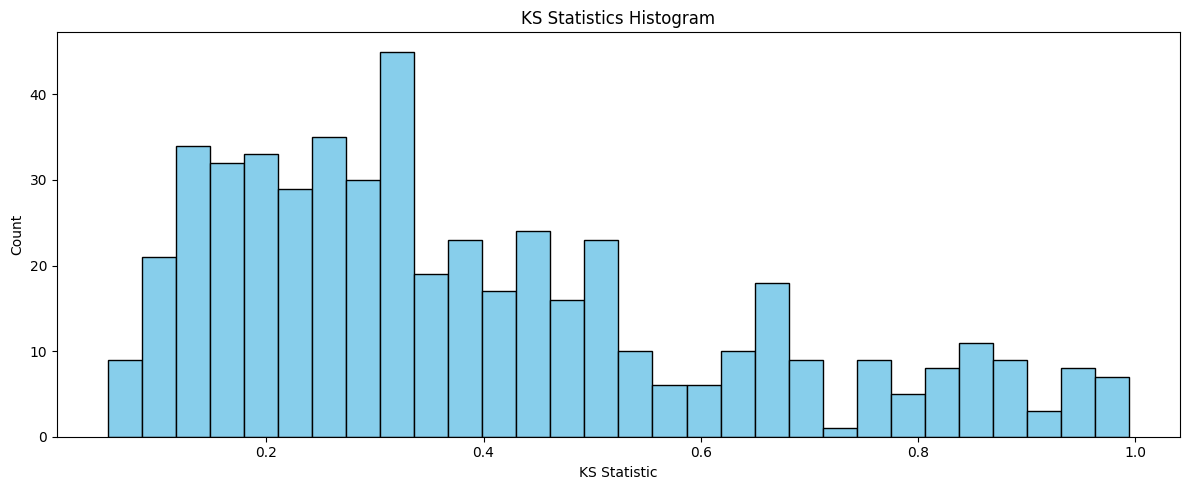

217
Indices with KS stats less than threshold (0.3): [2, 5, 7, 9, 10, 11, 12, 13, 16, 19, 20, 23, 24, 25, 27, 28, 32, 34, 36, 44, 51, 53, 70, 79, 81, 83, 85, 95, 97, 100, 105, 108, 109, 112, 113, 117, 118, 124, 127, 128, 129, 132, 133, 134, 136, 137, 138, 140, 142, 149, 151, 153, 156, 158, 159, 160, 161, 164, 169, 170, 172, 173, 176, 177, 178, 180, 181, 182, 183, 184, 185, 187, 188, 190, 191, 196, 201, 202, 205, 206, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 228, 234, 235, 239, 240, 243, 245, 247, 248, 249, 250, 252, 253, 263, 266, 267, 268, 269, 270, 272, 275, 276, 282, 284, 285, 287, 291, 292, 294, 295, 299, 301, 302, 304, 309, 311, 313, 315, 318, 329, 333, 335, 336, 339, 341, 343, 344, 347, 348, 349, 352, 356, 357, 358, 359, 360, 364, 366, 367, 369, 371, 372, 374, 375, 376, 380, 381, 382, 385, 386, 389, 391, 392, 397, 401, 408, 410, 411, 412, 417, 418, 419, 420, 421, 422, 424, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 440, 441, 442, 443,

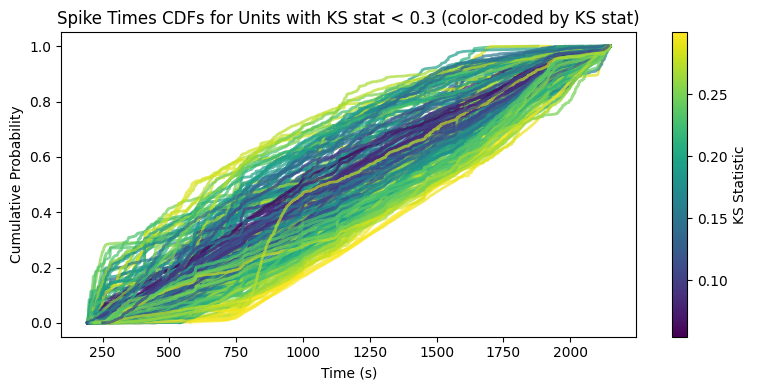

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
import matplotlib as mpl

firingRates_all = spike_times.metadata["rate"]
task_times = data["TaskTimes"]
beh_epochs = nap.IntervalSet(start=task_times.start, end=task_times.end)
spike_times_beh = spike_times.restrict(beh_epochs)
firingRates_beh = spike_times_beh.metadata["rate"]

start_time = task_times.start
end_time = task_times.end
ks_stats = np.zeros(len(spike_times))
ks_pvals = np.zeros(len(spike_times))
for u in range(len(spike_times)):
    # get spike times for this unit
    test = spike_times[u].as_series().index.values

    # The null hypothesis is that the spike times are uniformly distributed between start_time and end_time
    if len(test) > 1:
        min_time = start_time[0]
        max_time = end_time[-1]
        # Normalize spike times to [0, 1] for KS test against uniform
        normalized_spike_times = (test - min_time) / (max_time - min_time)
        ks_result = kstest(normalized_spike_times, 'uniform')
        ks_stats[u] = ks_result.statistic
        ks_pvals[u] = ks_result.pvalue
    else:
        ks_stats[u] = np.nan
        ks_pvals[u] = np.nan

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(ks_stats, bins=30, color='skyblue', edgecolor='black')
ax.set_title('KS Statistics Histogram')
ax.set_xlabel('KS Statistic')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# look at reasonable cdf plots
threshold = 0.3
indices_keep = np.where(ks_stats < threshold)[0].tolist()
print(len(indices_keep))
print(f"Indices with KS stats less than threshold ({threshold}):", indices_keep)

# Normalize KS stats for color mapping
ks_stats_keep = ks_stats[indices_keep]
norm = mpl.colors.Normalize(vmin=np.nanmin(ks_stats_keep), vmax=np.nanmax(ks_stats_keep))
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(8, 4))
for idx in indices_keep:
    test = spike_times[idx].as_series().index
    sorted_spikes = np.sort(test)
    cdf = np.arange(1, len(sorted_spikes)+1) / len(sorted_spikes)
    color = cmap(norm(ks_stats[idx]))
    ax.plot(sorted_spikes, cdf, lw=2, alpha=0.7, color=color, label=f'Unit {idx} (KS={ks_stats[idx]:.2f}, p={ks_pvals[idx]:.2g})')
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='KS Statistic')
ax.set_title(f'Spike Times CDFs for Units with KS stat < {threshold} (color-coded by KS stat)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cumulative Probability')
fig.tight_layout()
plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# now apply ISI violation criteria to narrow down good neurons
violationThreshold = 3/1000 #for 3 ms isi refractory period, what used before, middle of range that kilosort cites
violationPct = np.zeros(len(spike_times))
for i in range(len(spike_times)):
    unit = spike_times[i]
    unit = unit.as_series().index
    if len(unit) < 100:
        violationPct[i] = 1 
    else:
        isi = unit.diff()[1:len(unit)]
        violations = np.where(isi<violationThreshold)
        violations = np.array(violations)
        violationPct[i] = violations.size/len(isi)

# now apply masks
KSLabels = spike_times.metadata["KSLabel"]
firingRates = firingRates_beh
mask1 = violationPct<3/100 # throwing out neurons with > 3% isi violations with isi = 3 ms; lose quite a bit with 5 ms esp when including cdf stats
mask2 = firingRates>0.5 # firing rate > 0.5 ms during all behavior epochs
mask3 = KSLabels!="noise" # not noise per auto label
mask4 = ks_stats < 0.3 # KS stat < 0.3 (stability across recording)
mask = mask1 & mask2 & mask3 & mask4
indicesFinal = firingRates.index[mask]
spike_times_good = spike_times_beh[indicesFinal]
print(spike_times_good)
print(f"Number of good neurons: {len(spike_times_good)}")

# Calculate fraction of units in spike_times_good with label "mua"
kslabels_good = spike_times_good.metadata["KSLabel"]
num_mua = np.sum(kslabels_good == "mua")
frac_mua = num_mua / len(spike_times_good) if len(spike_times_good) > 0 else np.nan
print(f"Fraction of 'mua' units in spike_times_good: {frac_mua:.3f}")

### criteria for unit selection
## 1) at least 100 spikes, redundant with the firing rate criterion but just in case
# there is a very short recording session
## 2) firing rate > 0.5 ms, necessary for assembly code to mitigate spurious assembly
# identification
## 3) isi violations < 3% (Rutishauser lab reference) with a period of 5 ms (Kiosort
# reference)
## 4) kilosort label != "noise". A significant minority of "mua" units will survive which
# sounds like is ok per quinn. Can revisit prn. 

Index    rate      unit_name    KSLabel    Amplitude    KSLabel_repeat    original_cluster_id    ...
-------  --------  -----------  ---------  -----------  ----------------  ---------------------  -----
7        11.70713  7            good       12.7         good              7                      ...
9        4.67943   9            mua        11.1         mua               9                      ...
10       4.0053    10           good       12.7         good              10                     ...
11       3.15144   11           good       10.5         good              11                     ...
12       2.23276   12           good       10.9         good              12                     ...
13       3.1921    13           good       10.1         good              13                     ...
16       9.89393   16           good       14.0         good              16                     ...
...      ...       ...          ...        ...          ...               ...            

In [17]:
speech_prod_times = data["ProdSpeechWords"]
speech_sens_times = data["StimSpeechWords"]
taskStims = data["TaskStims"]
taskCues = data["TaskCues"]


print(speech_prod_times)
print(speech_sens_times)

index    start           end                 segment_index    words      trial_index    source    task    type                                                            ...
0        223.111303419   223.301303419       0                uh         0              prod      lmv     uh                                                              ...
1        223.600023419   223.740023419       0                uh         1              prod      lmv     uh                                                              ...
2        224.074452419   224.354452419       0                i          2              prod      lmv     i                                                               ...
3        224.474894419   224.584894419       0                i          3              prod      lmv     i                                                               ...
4        225.216386419   225.316385419       0                i          4              prod      lmv     i didn't                

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# get all speech onsets for speaking (prod) and listening (sens)
speech_prod_times = data["ProdSpeechWords"]
speech_sens_times = data["StimSpeechWords"]
# print(speech_prod_times)
# print(speech_sens_times)

prod_onsets = nap.Ts(speech_prod_times.start)
prod_offsets = nap.Ts(speech_prod_times.end)
sens_onsets = nap.Ts(speech_sens_times.start)
sens_offsets = nap.Ts(speech_sens_times.end)

# can define epochs if care about specific task but I don't 
# refer to ex.ipynb if care to epoch for a specific task

# now define neurons that are significantly active during prod and sens
from scipy.stats import ttest_rel

runList = indicesFinal
prod_rel_start = -0.10
prod_rel_end = 0
sens_rel_start = 0
sens_rel_end = 0.10

prod_firing_rates_dir = {}
sens_firing_rates_dir = {}

# Precompute all prod and sens intervals as IntervalSets for vectorized restriction
prod_starts = prod_onsets.as_series().index + prod_rel_start
prod_ends = prod_offsets.as_series().index + prod_rel_end
prod_tstat = np.zeros(len(runList))
prod_pval = np.zeros(len(runList))
sens_starts = sens_onsets.as_series().index + sens_rel_start
sens_ends = sens_offsets.as_series().index + sens_rel_end
sens_tstat = np.zeros(len(runList))
sens_pval = np.zeros(len(runList))

i = 0
for neuron in runList:
    spikes = spike_times_good[neuron]
    prod_firing_rates = np.zeros(len(prod_starts))
    sens_firing_rates = np.zeros(len(sens_starts))
    threshold_firing_rate = spike_times_good[neuron].rate 

    thresh_firing_rates = np.zeros(len(prod_starts))
    ct = 0
    for u in range(len(prod_starts)):
        prod_interval = nap.IntervalSet(start=prod_starts[u], end=prod_ends[u])
        spikes_this = spikes.restrict(prod_interval)
        prod_count = len(spikes_this)
        prod_rate = prod_count / (prod_ends[u] - prod_starts[u])    
        prod_firing_rates[ct] = prod_rate
        ct += 1
    prod_firing_rates_dir[neuron] = prod_firing_rates
    t_stat, p_val = ttest_rel(prod_firing_rates, np.full_like(prod_firing_rates, threshold_firing_rate), alternative='greater')
    prod_tstat[i] = t_stat
    prod_pval[i] = p_val

    thresh_firing_rates = np.zeros(len(sens_starts))
    ct = 0
    for u in range(len(sens_starts)):
        sens_interval = nap.IntervalSet(start=sens_starts[u], end=sens_ends[u])
        spikes_this = spikes.restrict(sens_interval)
        sens_count = len(spikes_this)
        sens_rate = sens_count / (sens_ends[u] - sens_starts[u])
        sens_firing_rates[ct] = sens_rate
        ct += 1
    sens_firing_rates_dir[neuron] = sens_firing_rates
    t_stat, p_val = ttest_rel(sens_firing_rates, np.full_like(sens_firing_rates, threshold_firing_rate), alternative='greater')
    sens_tstat[i] = t_stat
    sens_pval[i] = p_val

    i += 1

Indices with prod_pval < 0.05: [  2  11  14  18  19  21  23  24  25  27  28  30  31  34  36  37  38  39
  40  41  42  46  47  50  51  53  54  57  58  59  60  62  63  66  68  71
  73  74  76  77  78  80  82  83  87  91  94  97  98  99 101 106 107 111
 112 113 115 116 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 144 145 146 147 150]
Indices with sens_pval < 0.05: [  1   4   5   9  18  29  32  33  36  56  60  61  70  75  79  84  86  88
  93 104 105 110 114 117]
Indices with both prod_pval and sens_pval < 0.05: [18 36 60]
Percentage of neurons responsive to prod: 57.62%
Percentage of neurons responsive to sens: 15.89%
Percentage of neurons responsive to both: 1.99%
Index([  9,  12,  13,  23,  53, 124, 129, 132, 137, 187, 196, 201, 220, 240,
       249, 269, 272, 276, 295, 367, 369, 381, 401, 418],
      dtype='int64')
Index    rate      unit_name    KSLabel    Amplitude    KSLabel_repeat    original_cluster_id    ...
-------  --------  --

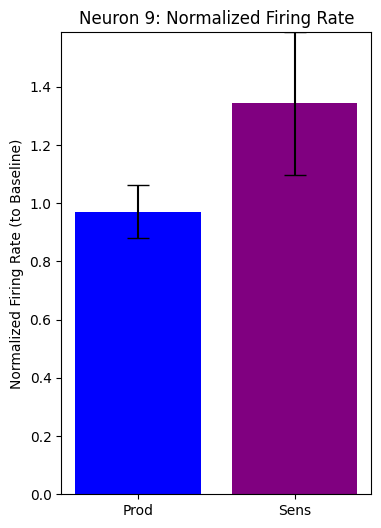

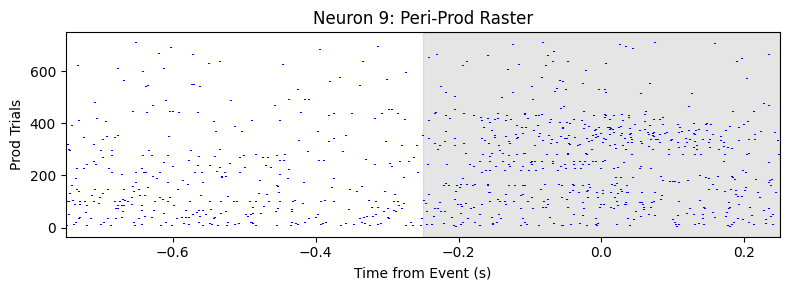

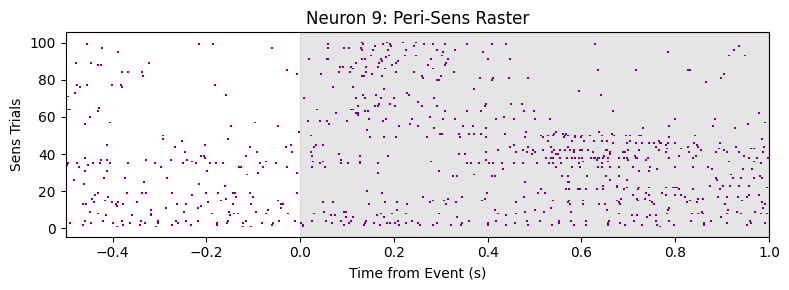

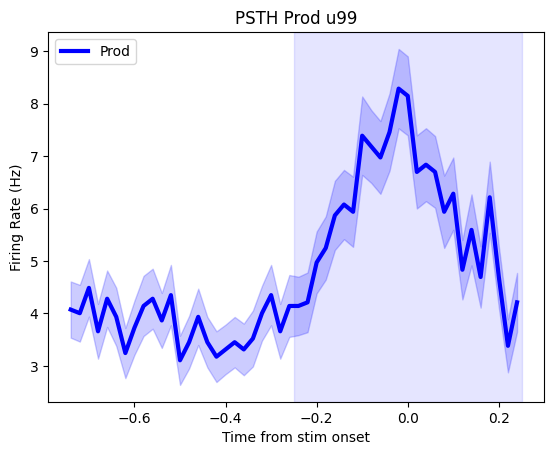

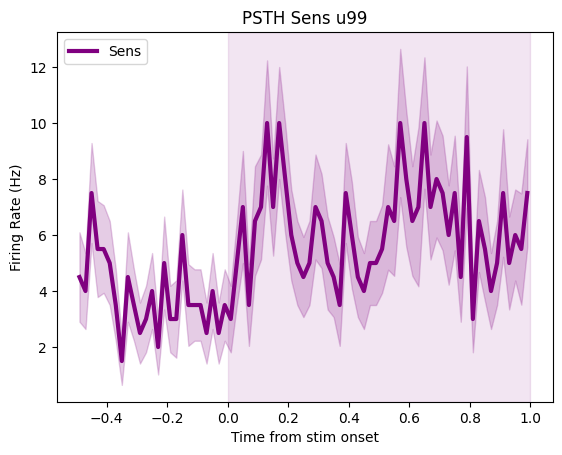

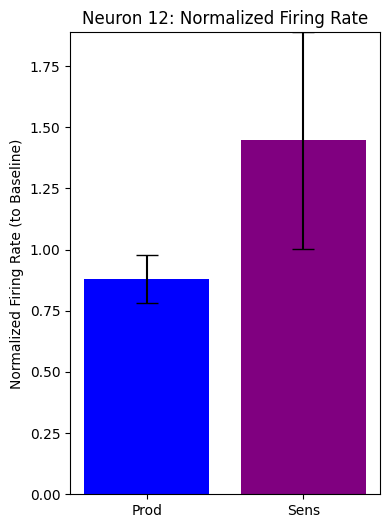

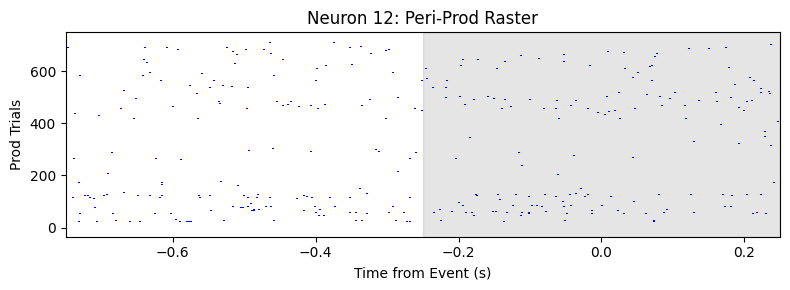

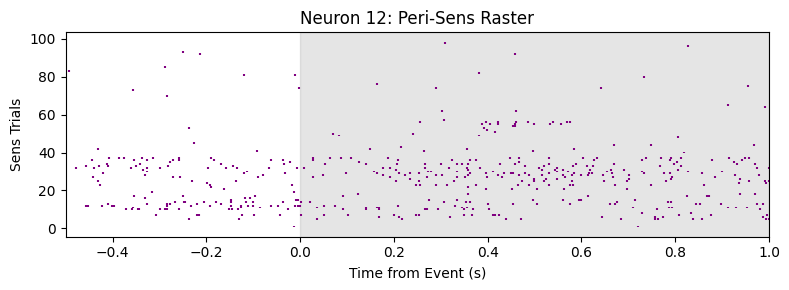

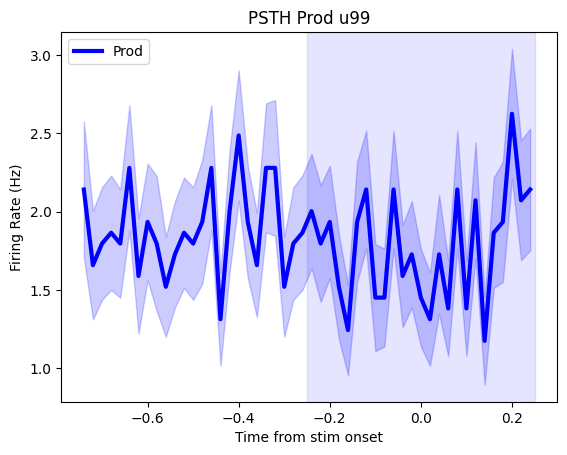

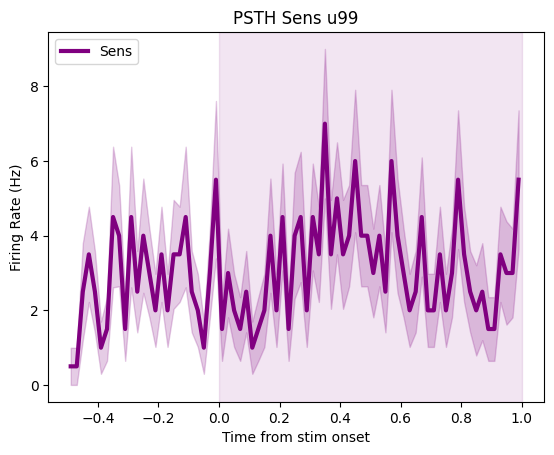

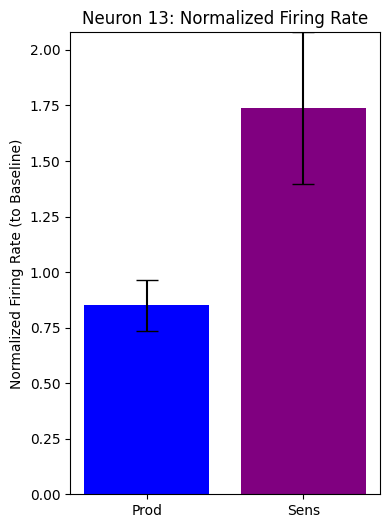

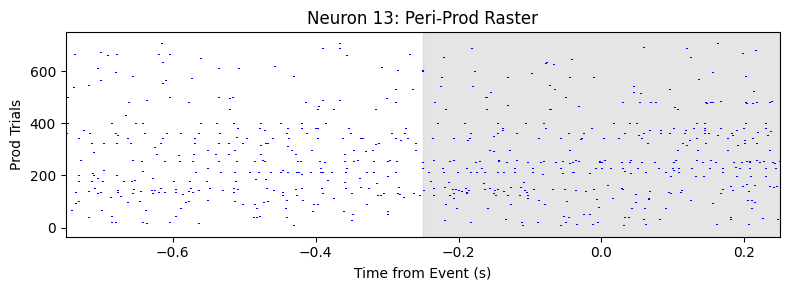

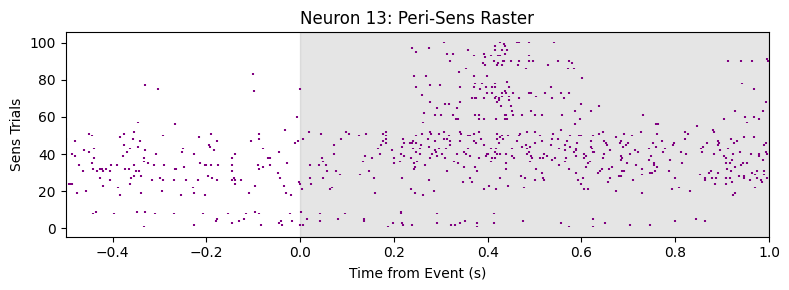

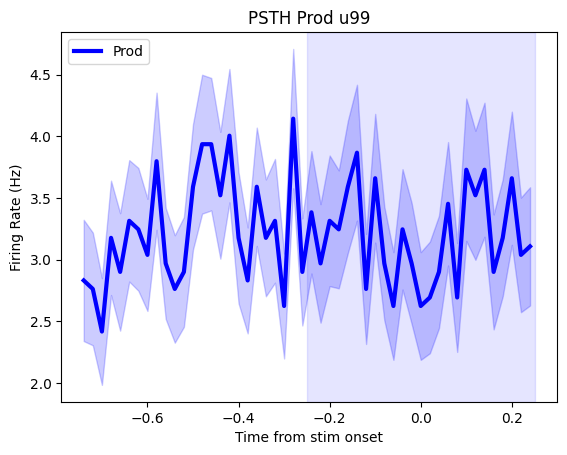

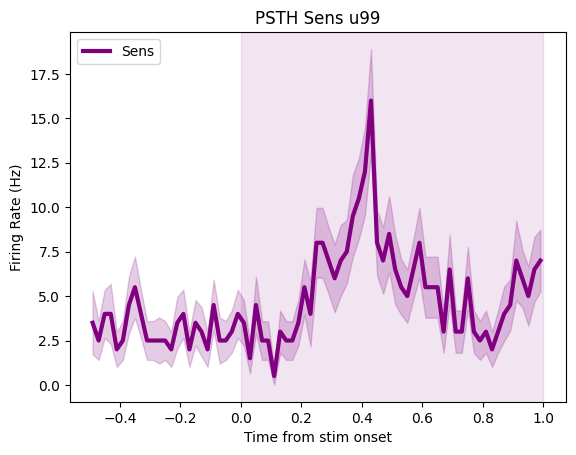

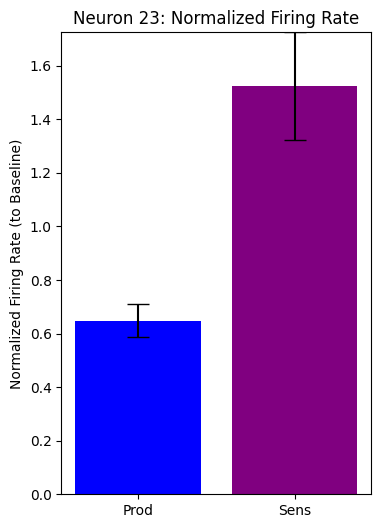

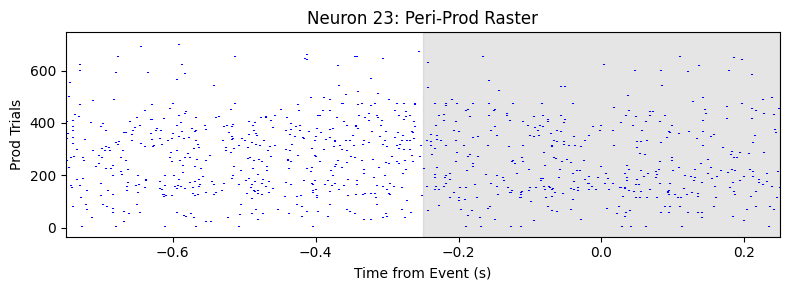

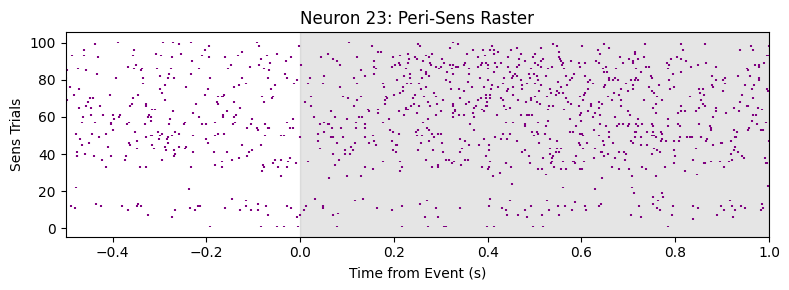

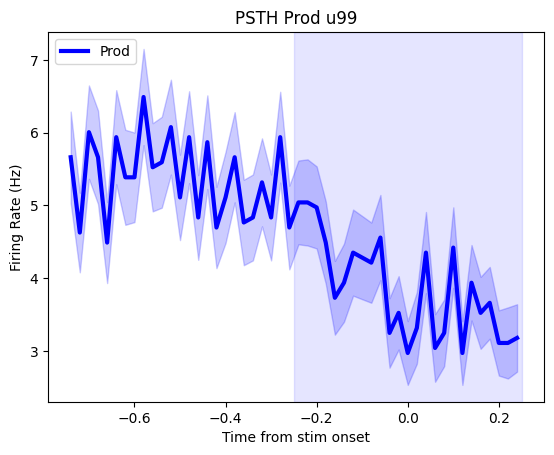

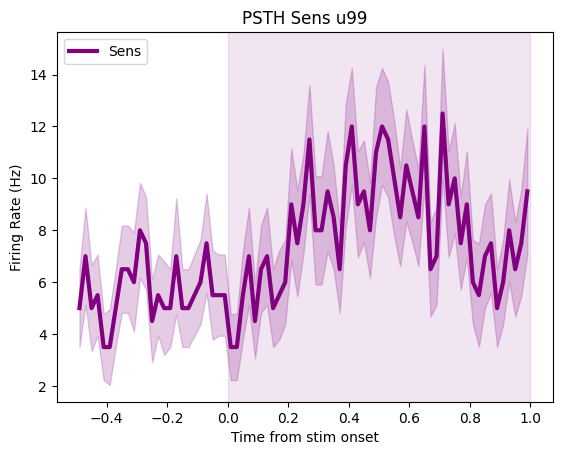

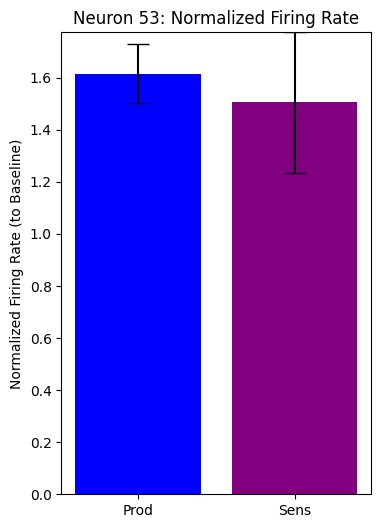

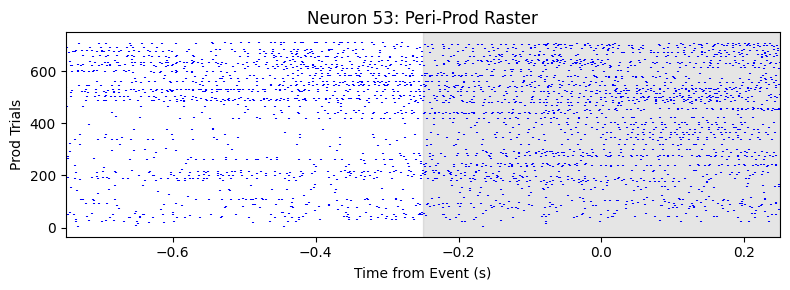

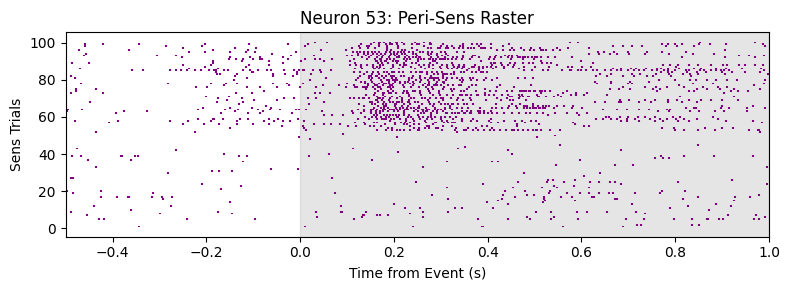

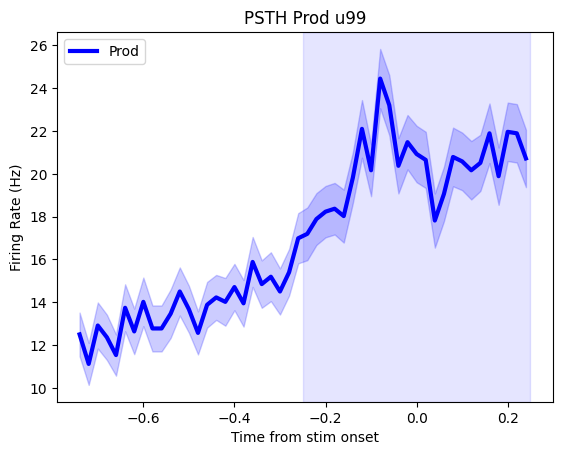

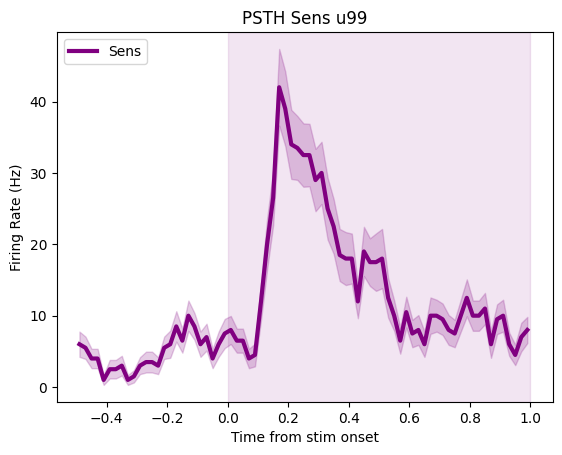

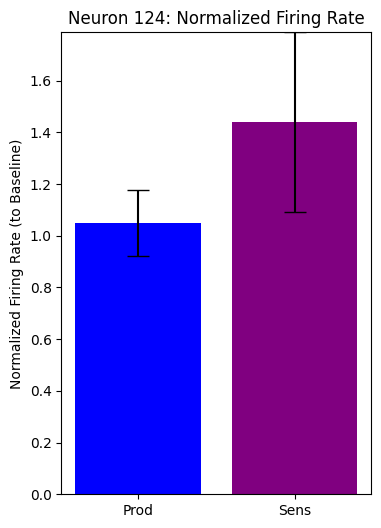

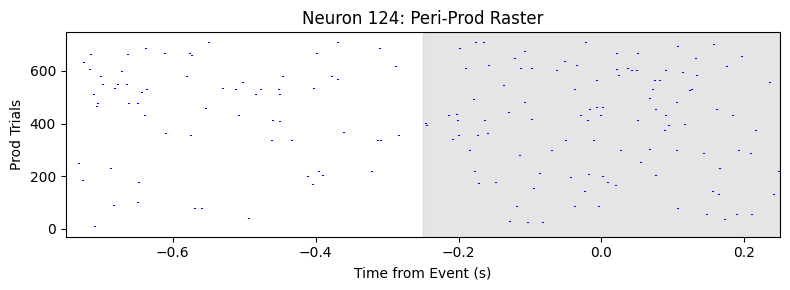

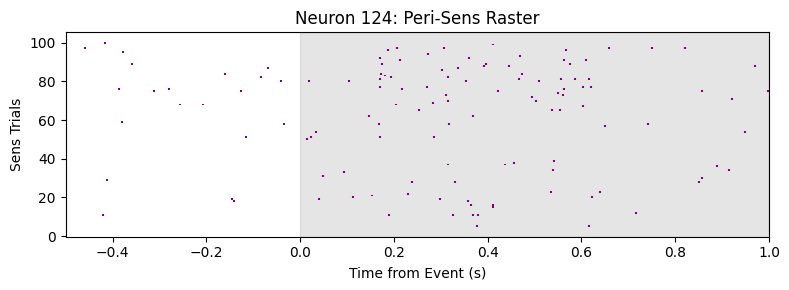

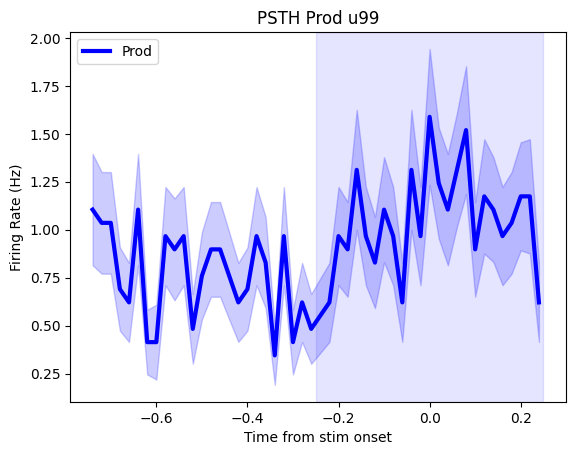

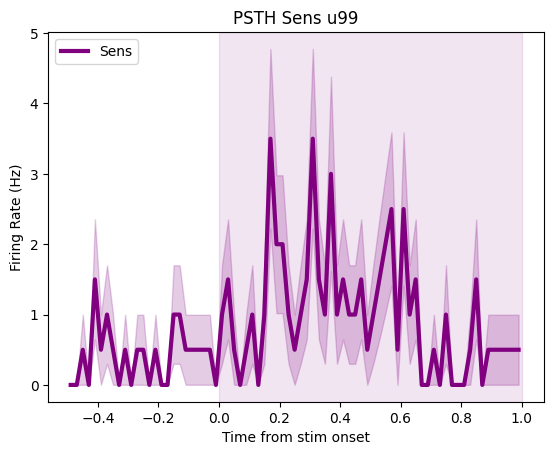

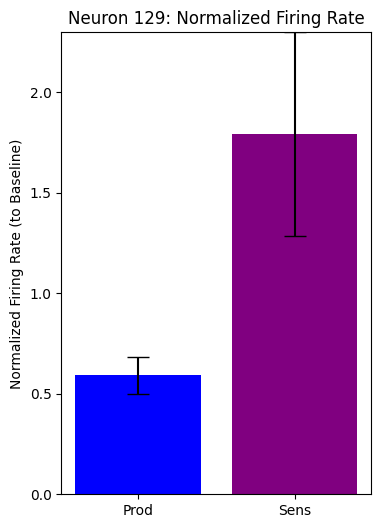

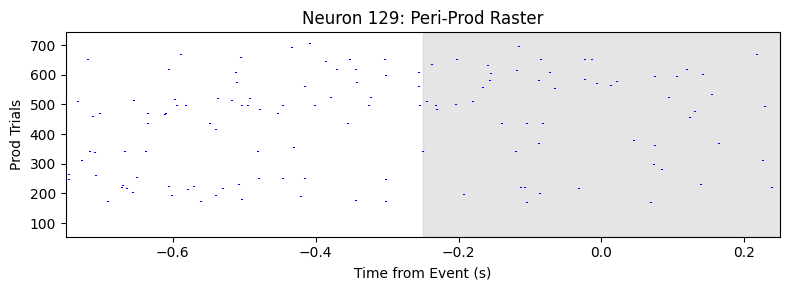

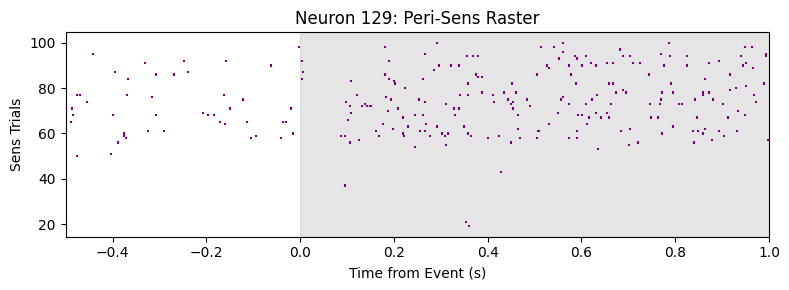

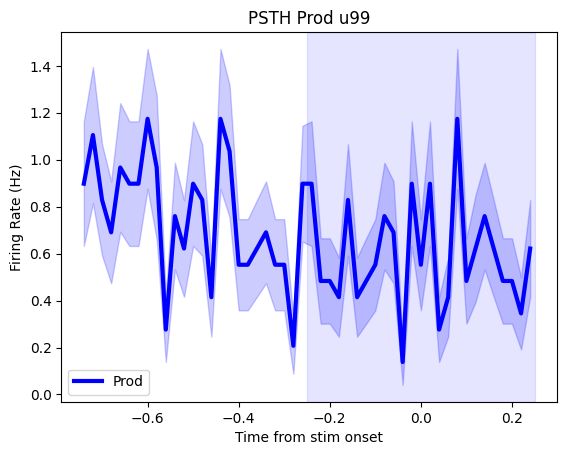

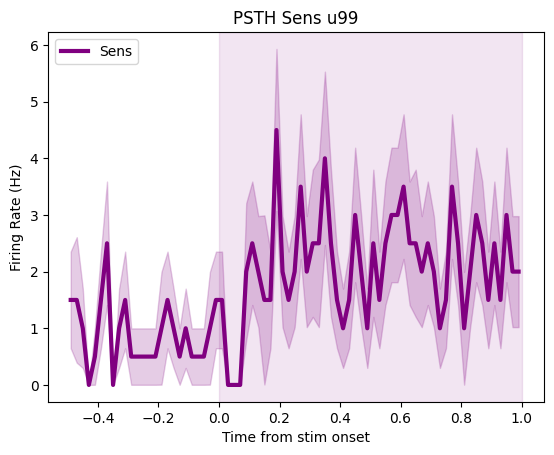

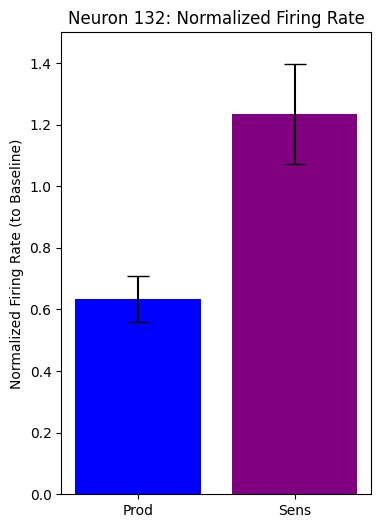

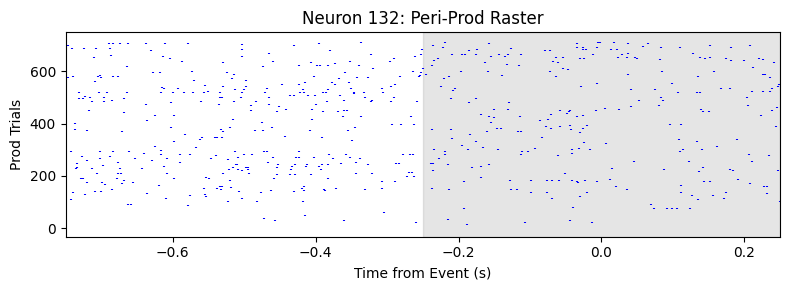

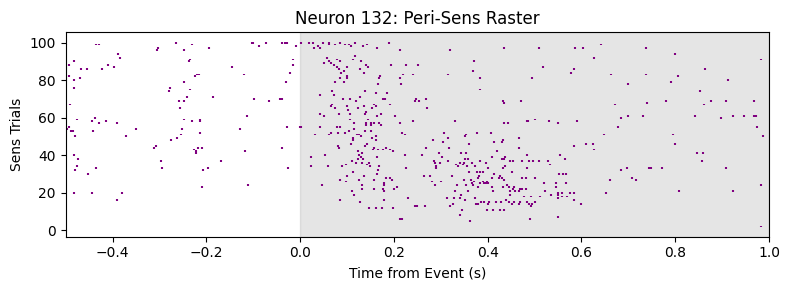

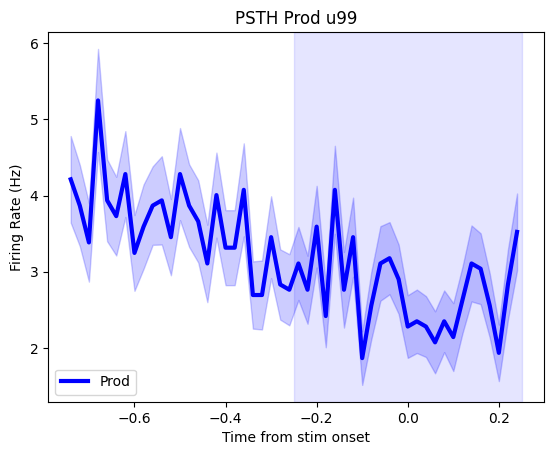

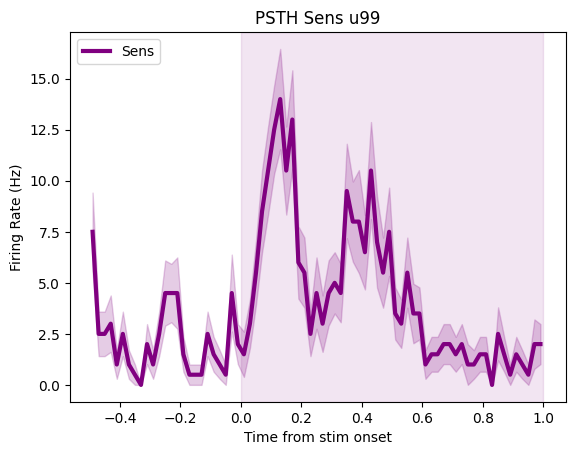

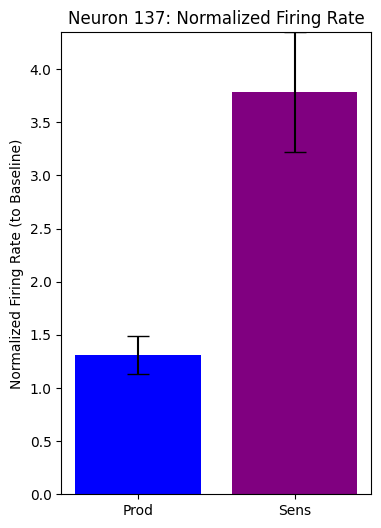

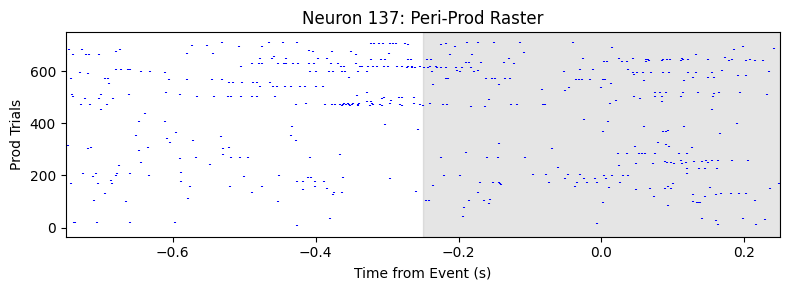

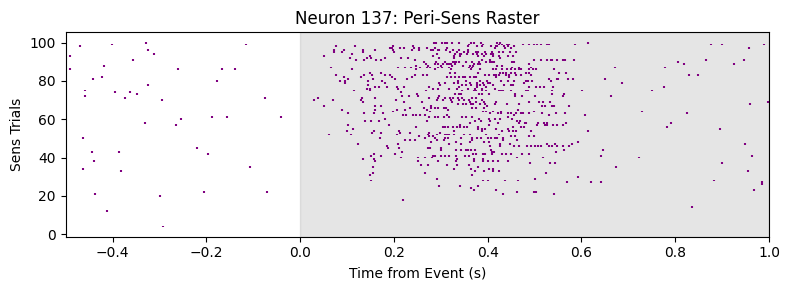

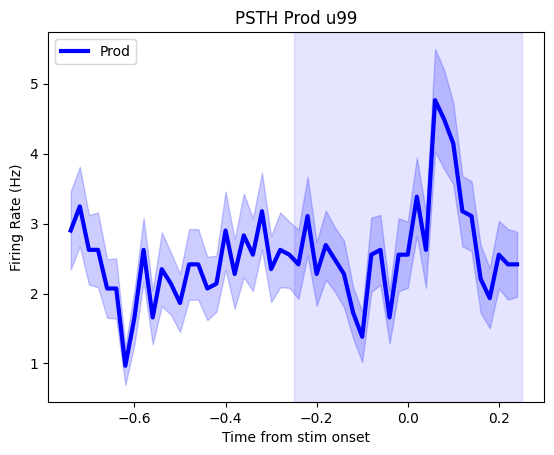

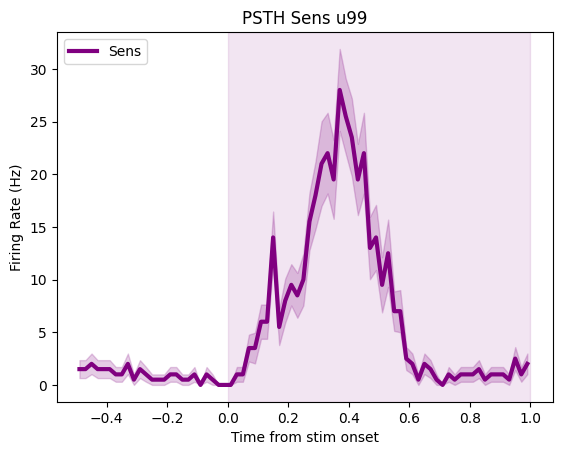

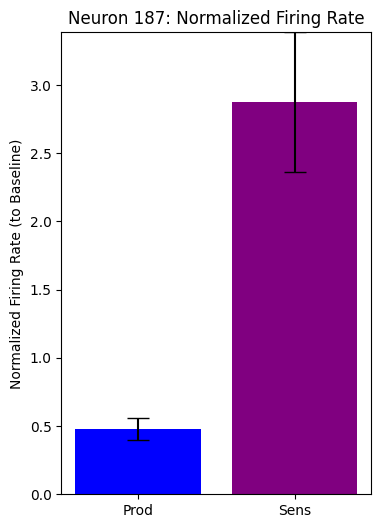

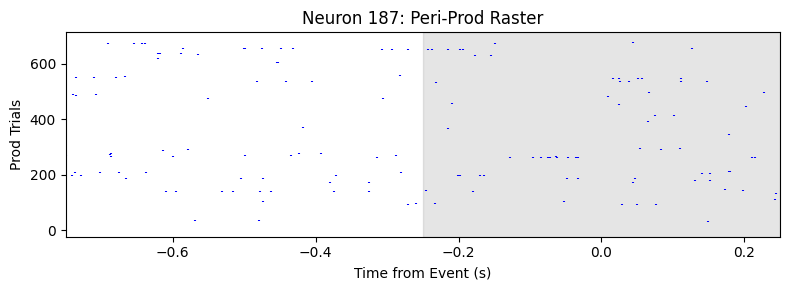

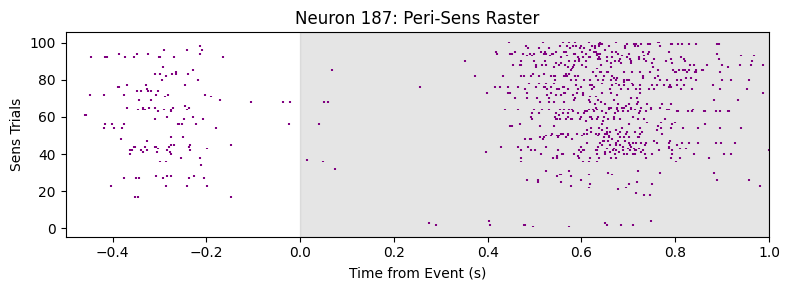

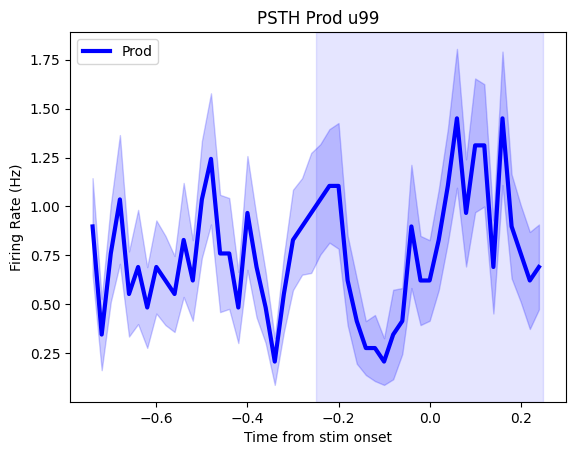

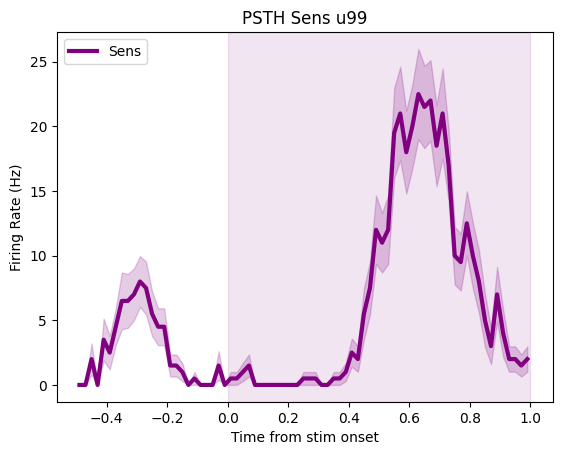

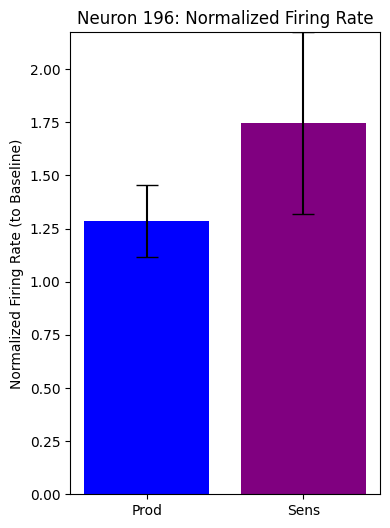

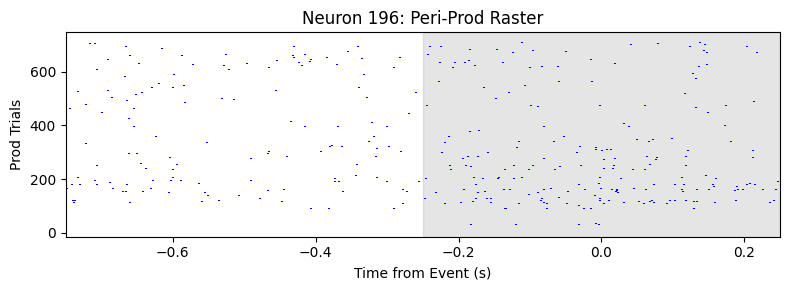

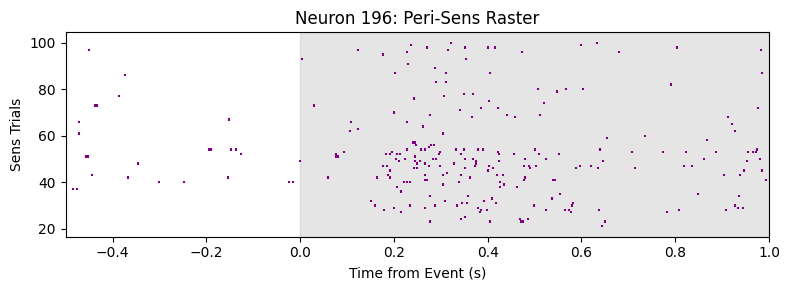

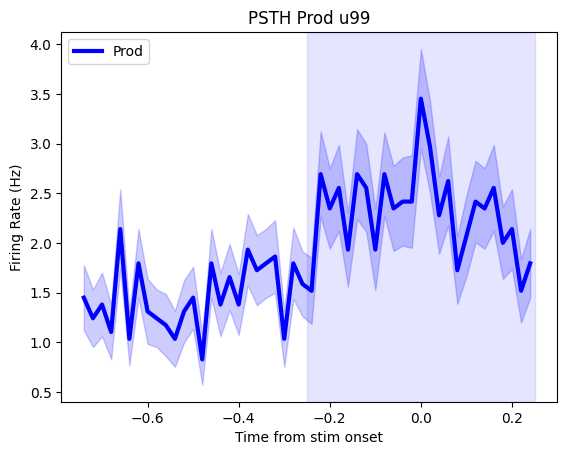

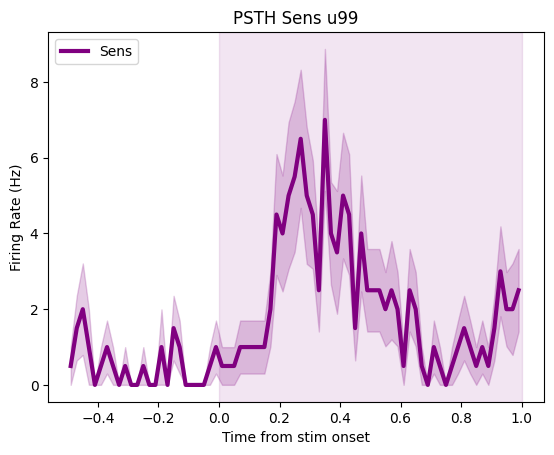

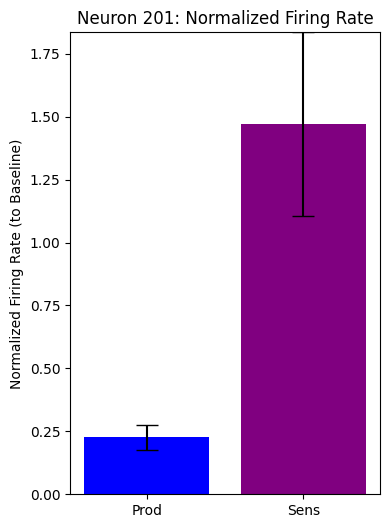

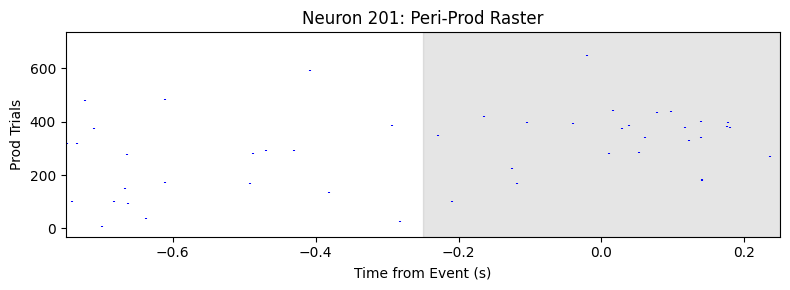

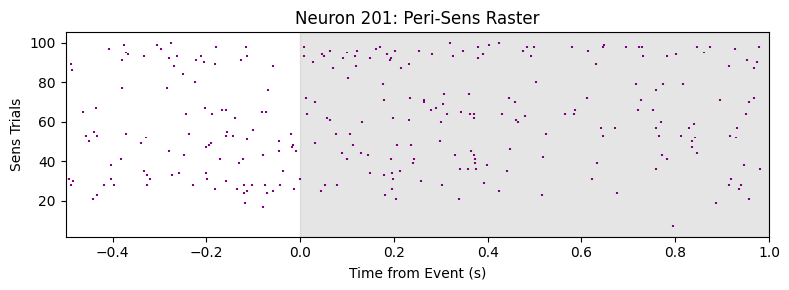

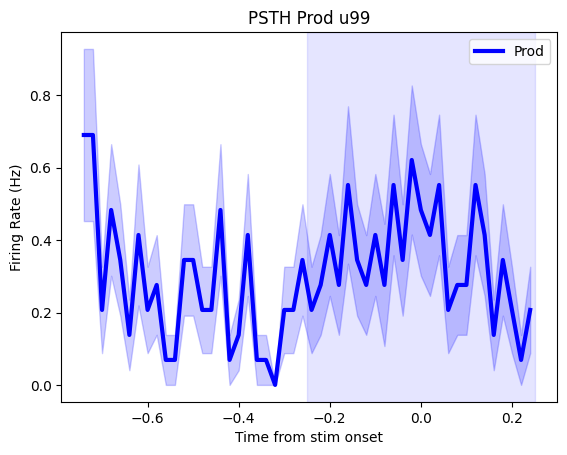

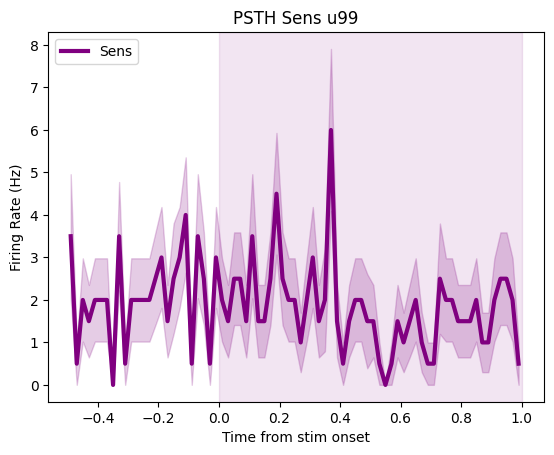

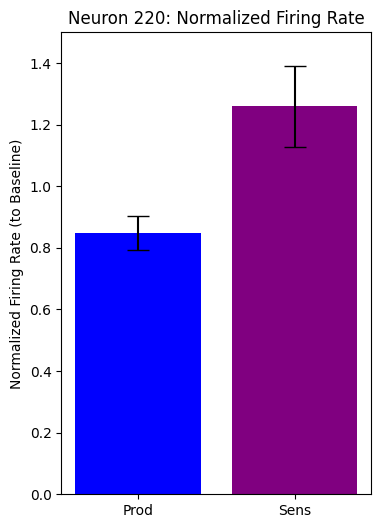

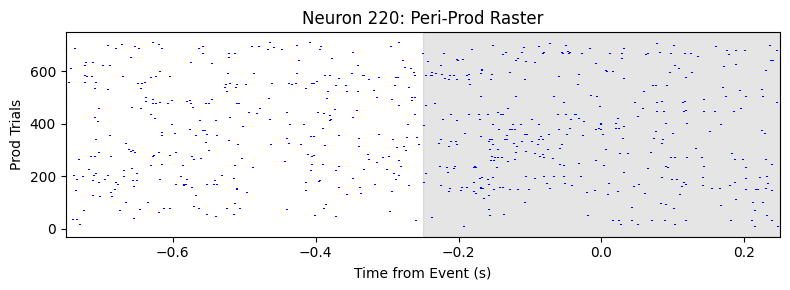

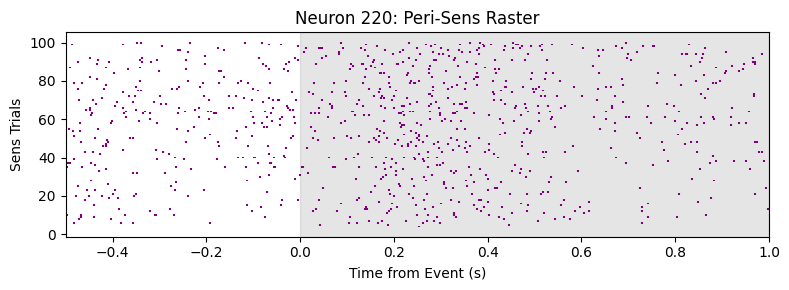

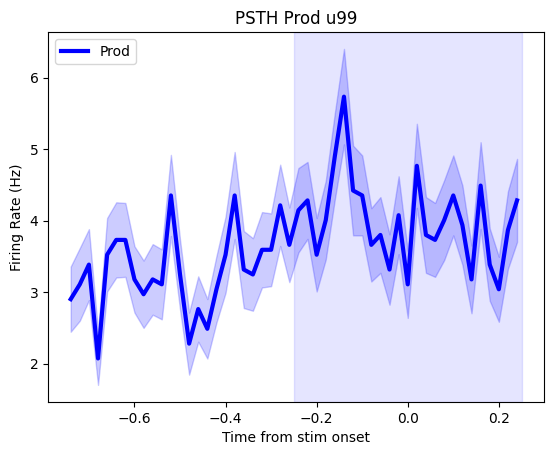

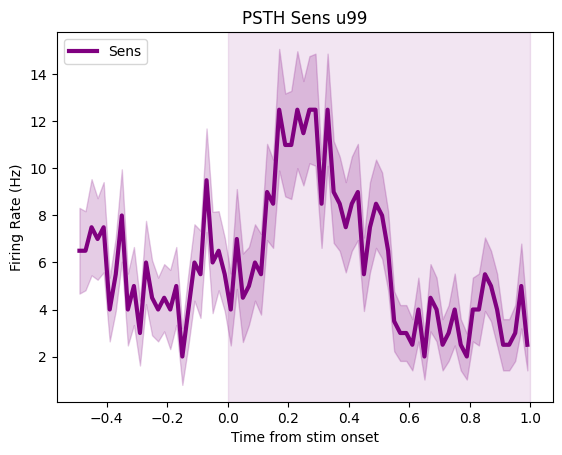

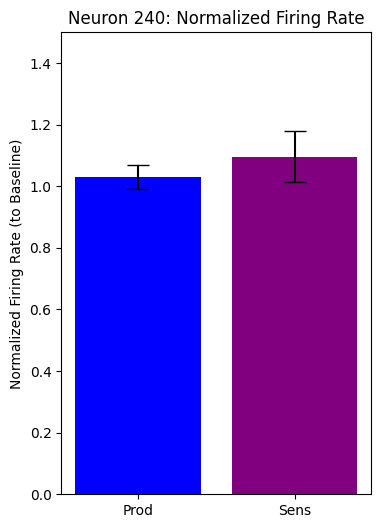

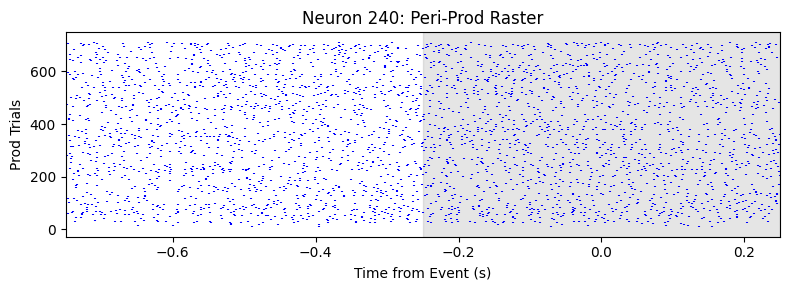

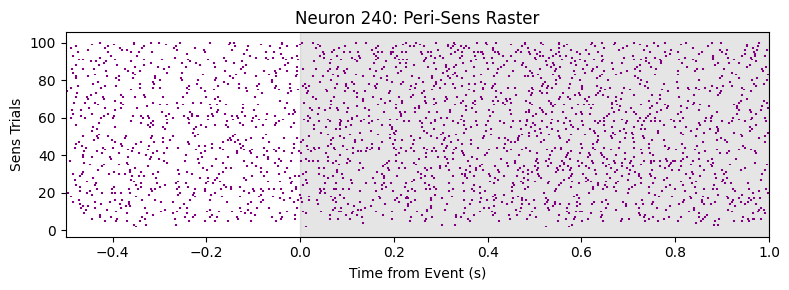

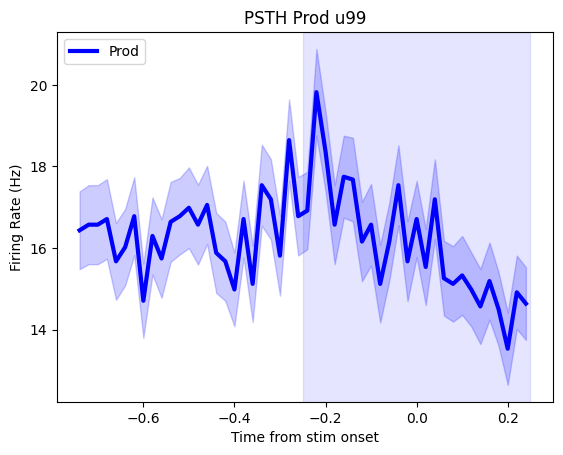

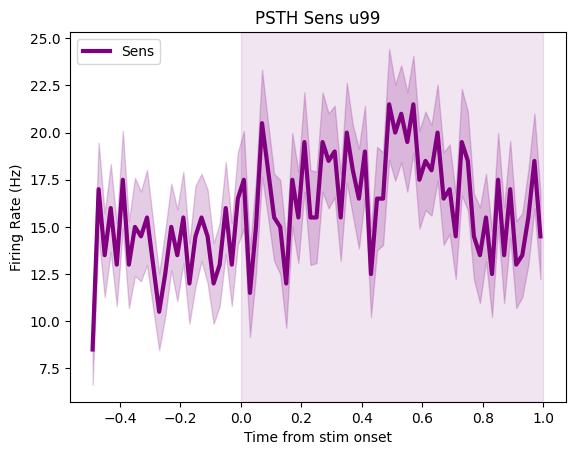

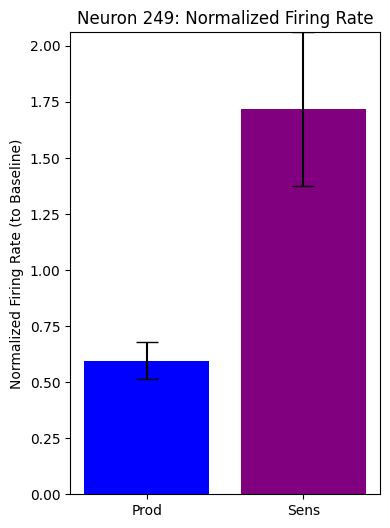

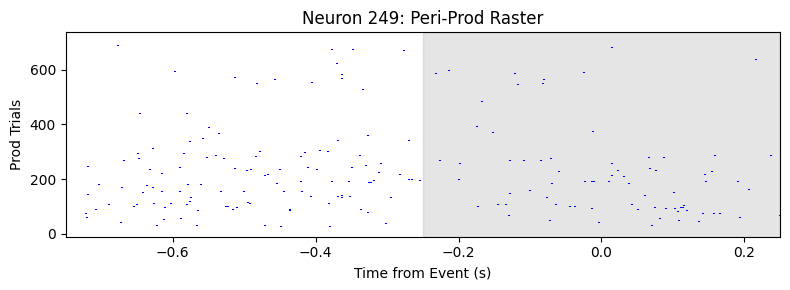

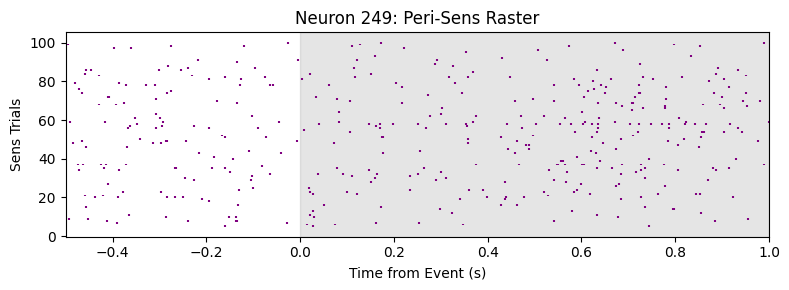

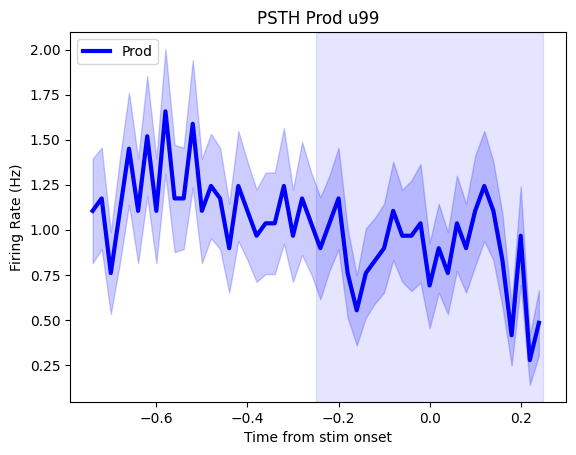

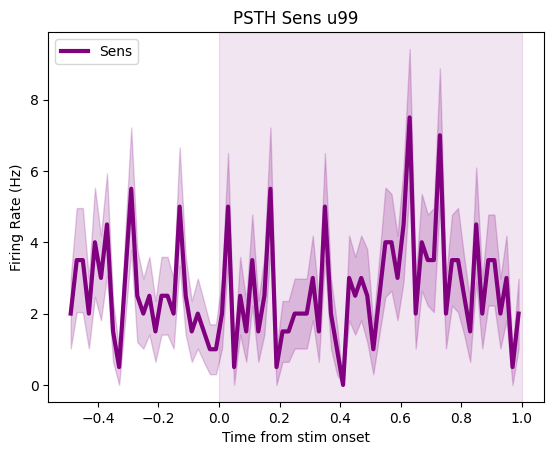

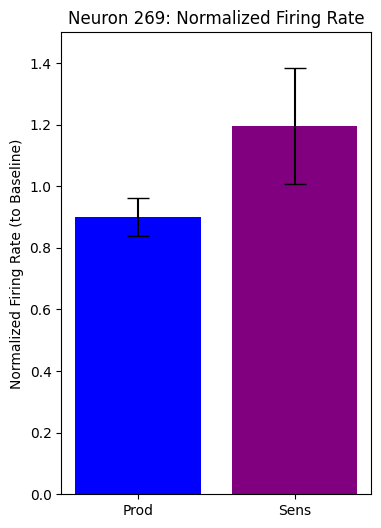

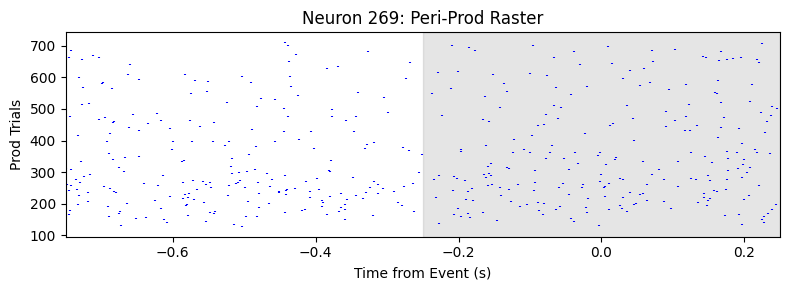

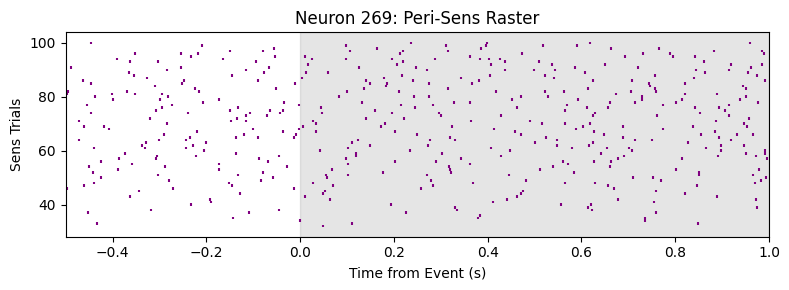

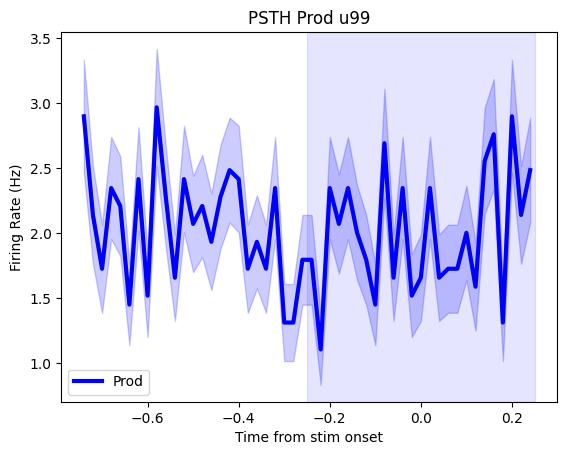

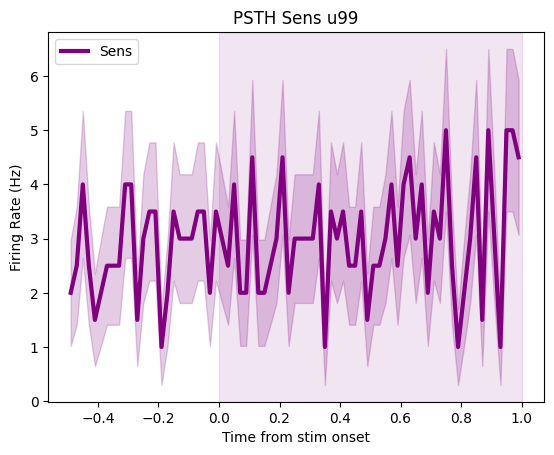

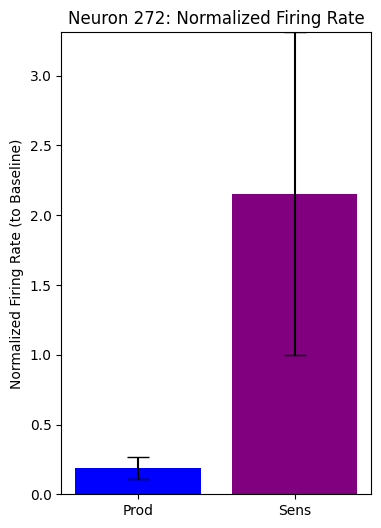

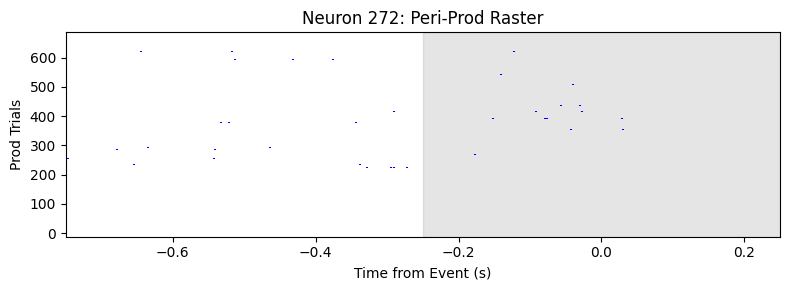

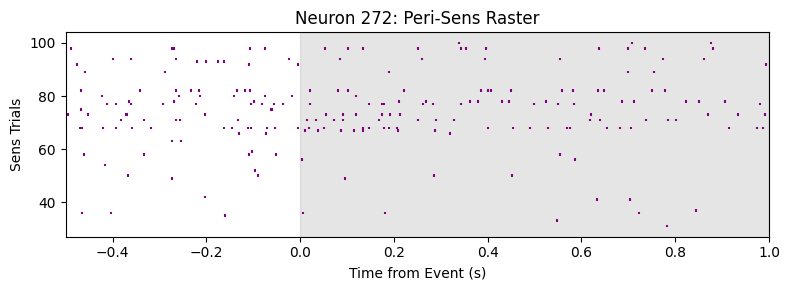

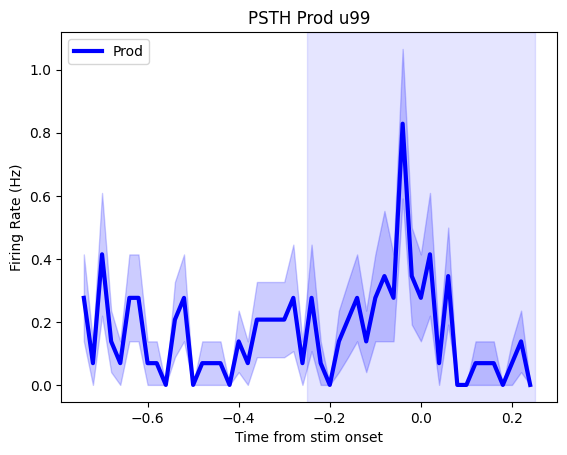

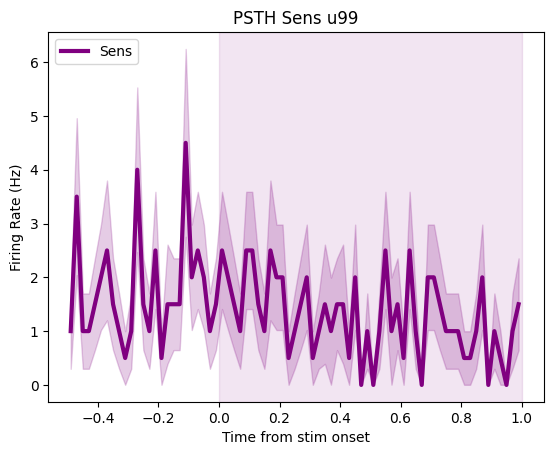

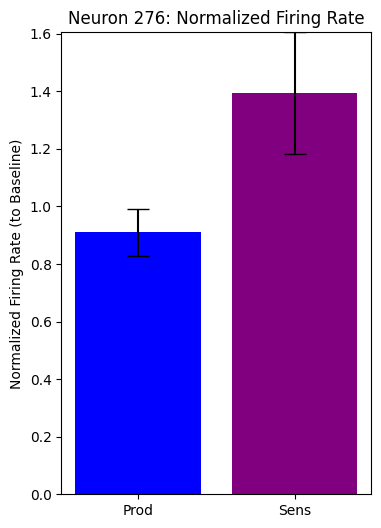

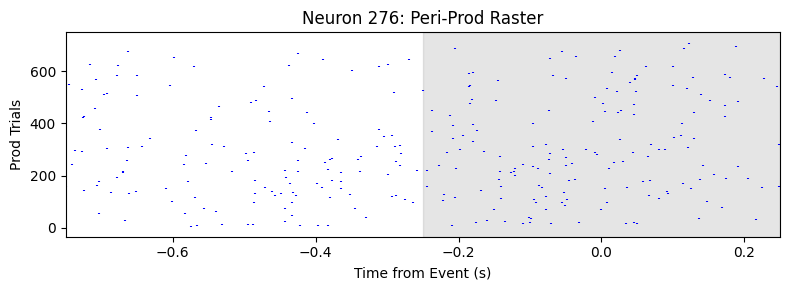

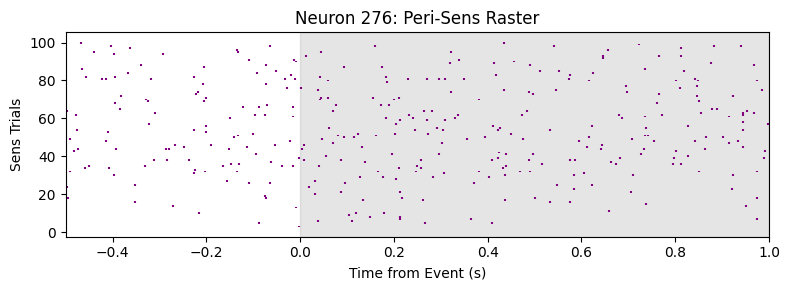

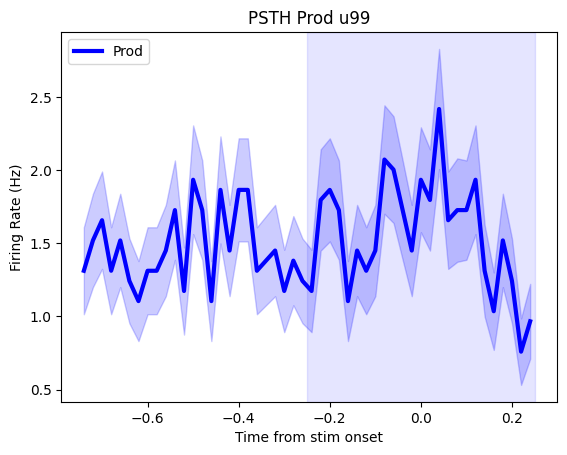

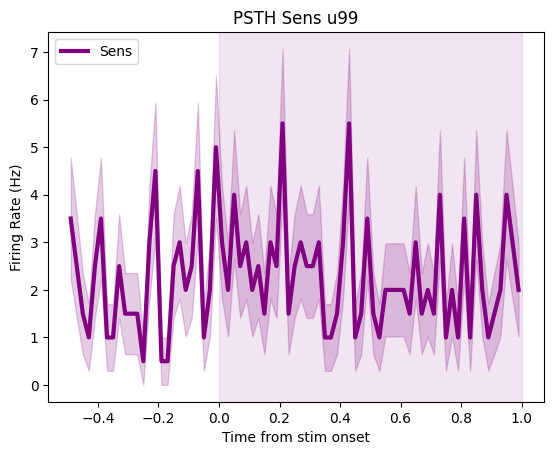

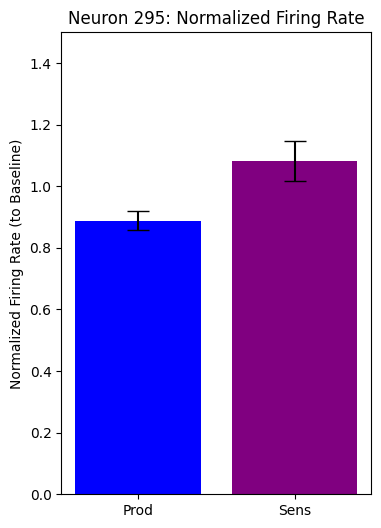

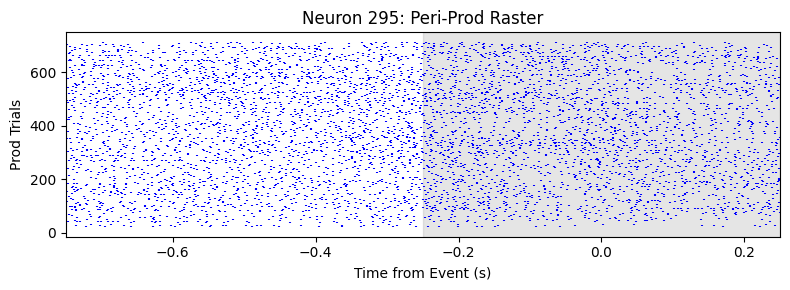

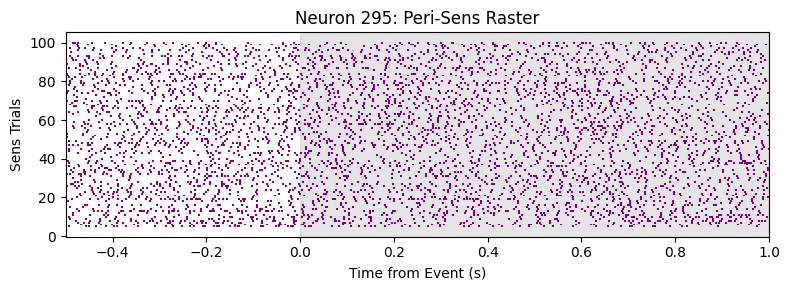

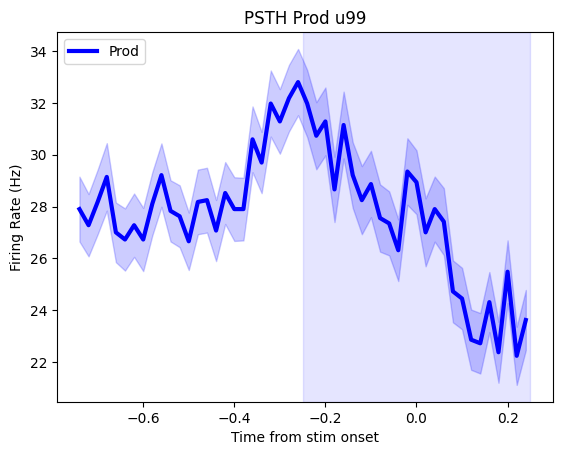

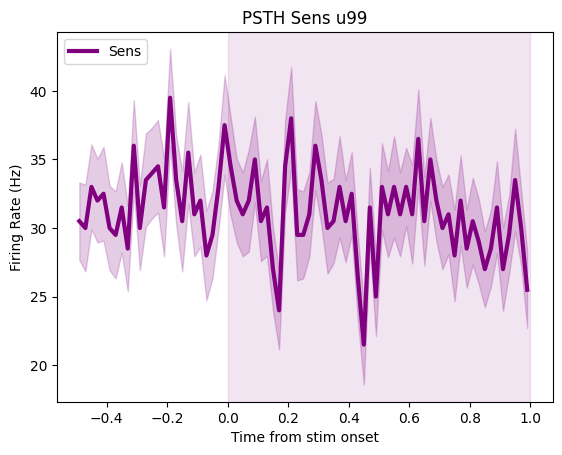

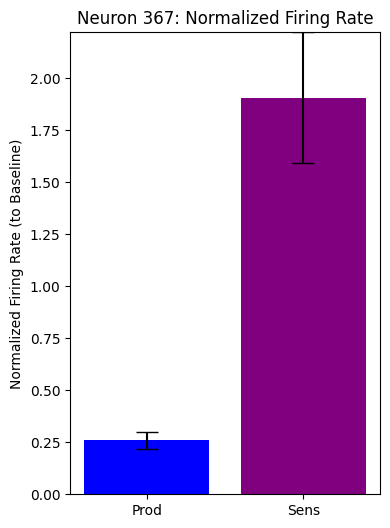

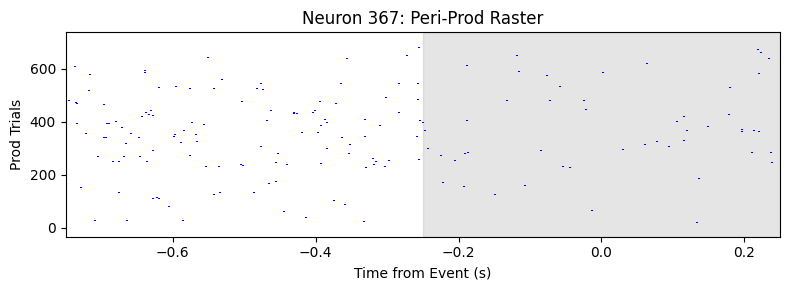

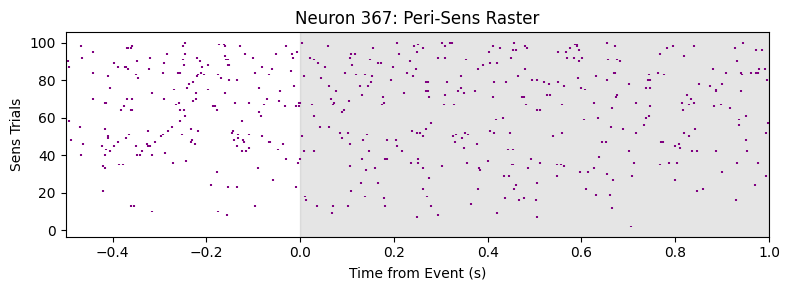

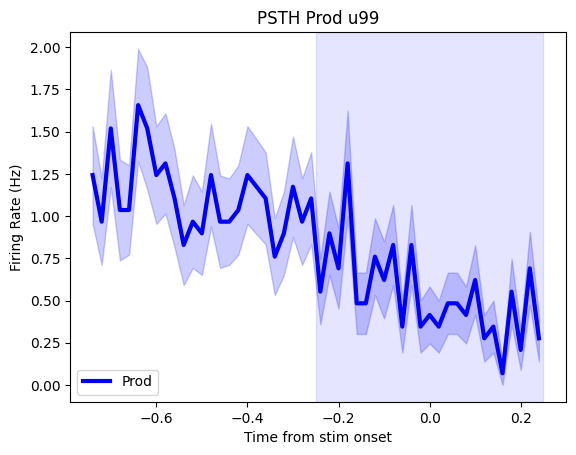

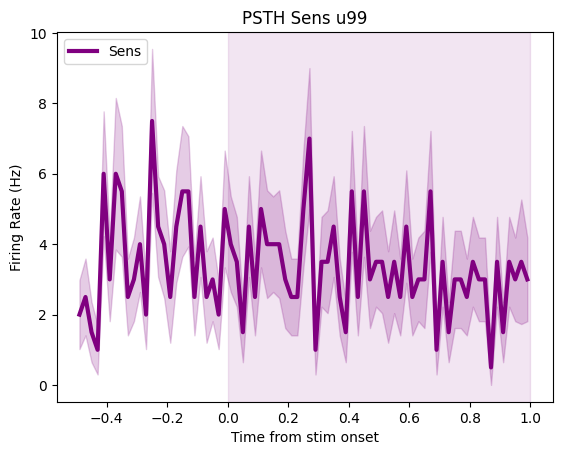

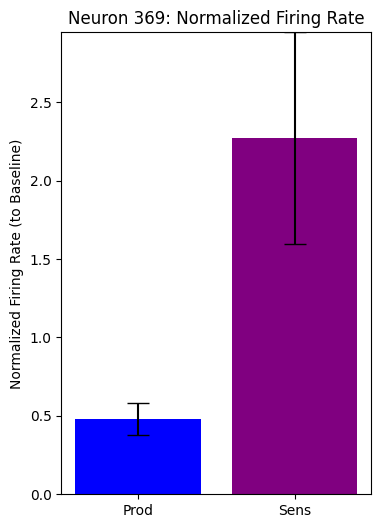

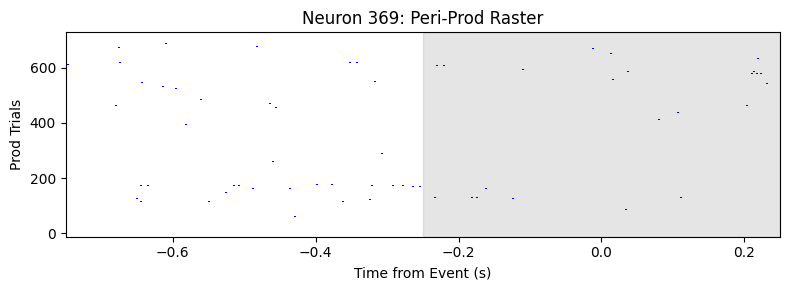

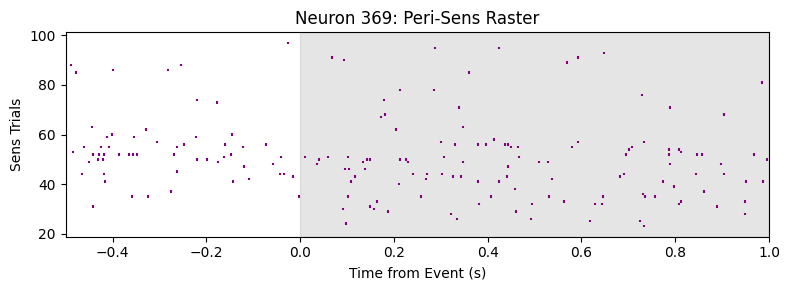

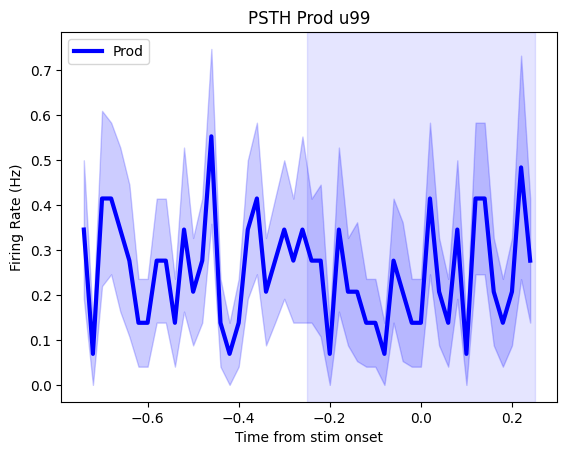

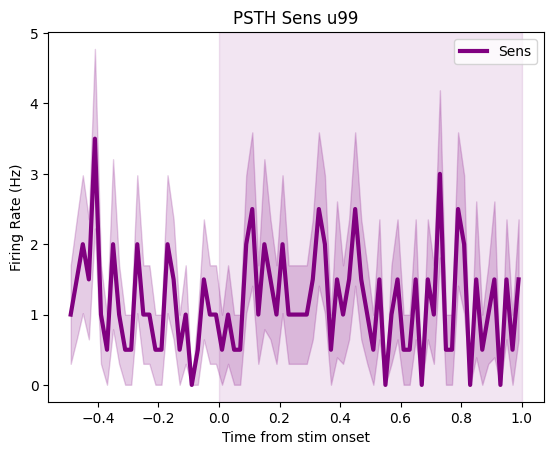

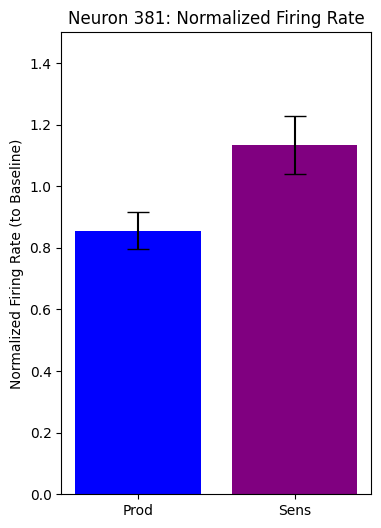

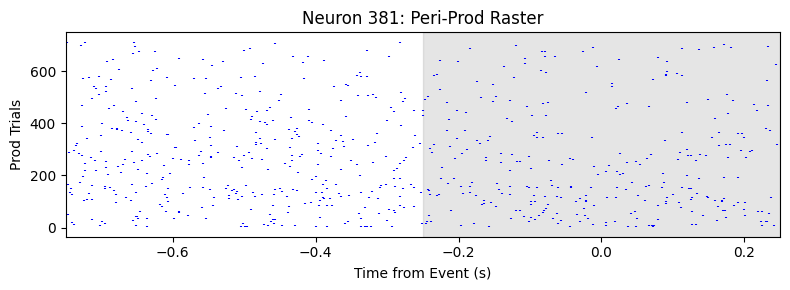

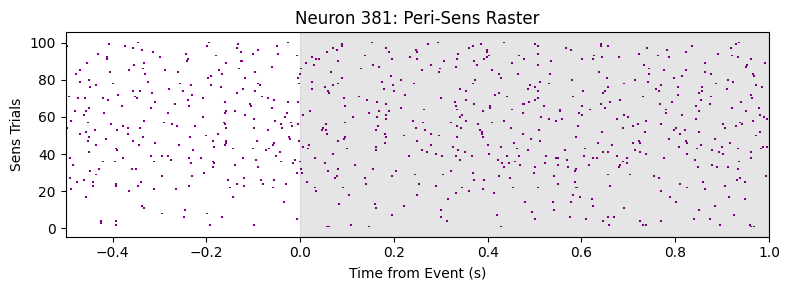

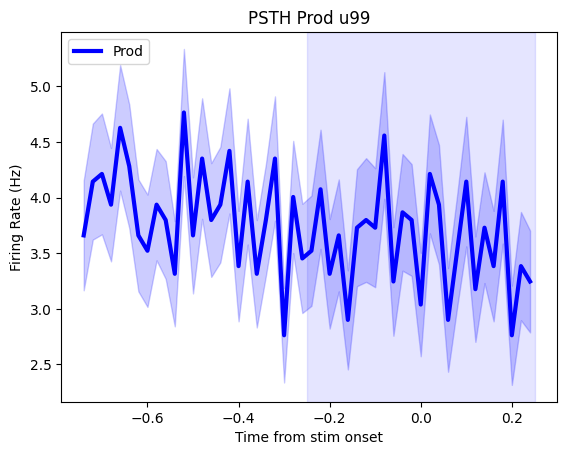

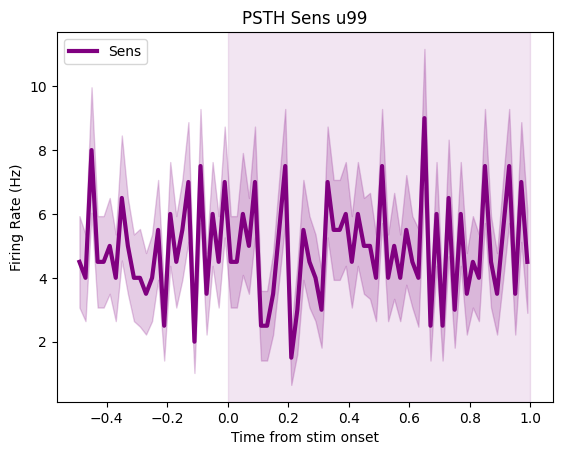

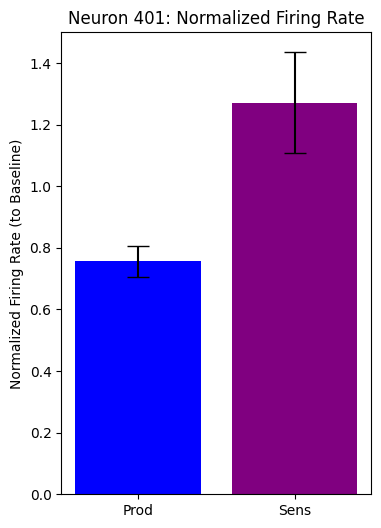

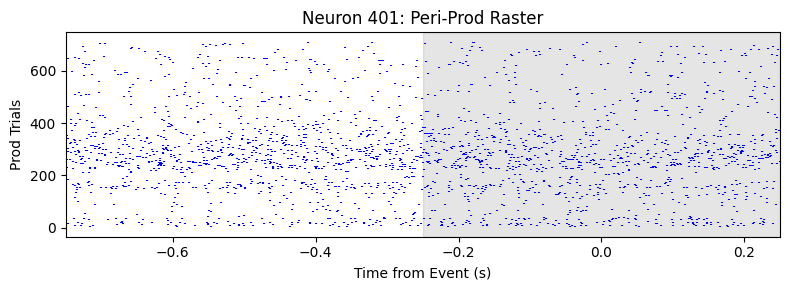

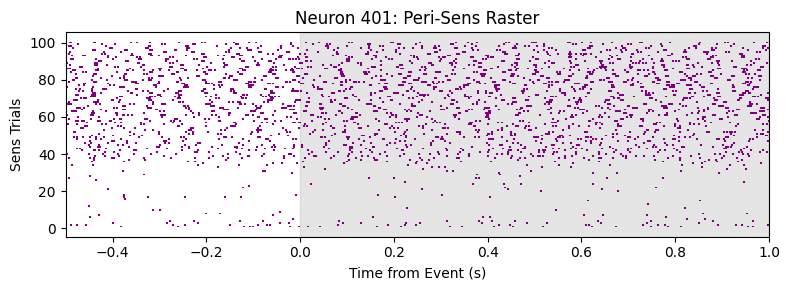

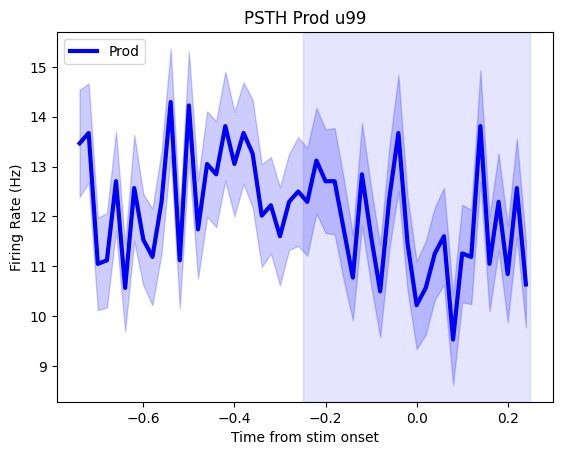

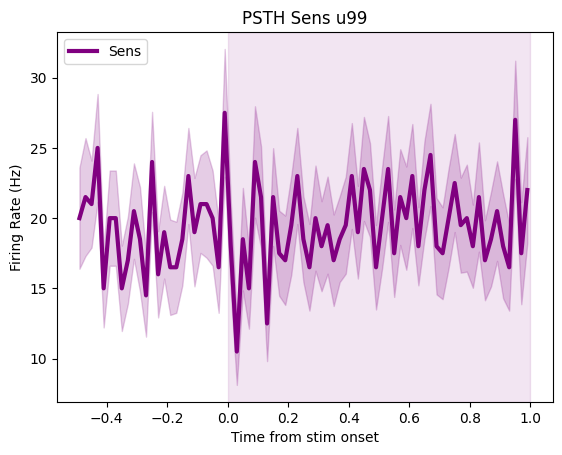

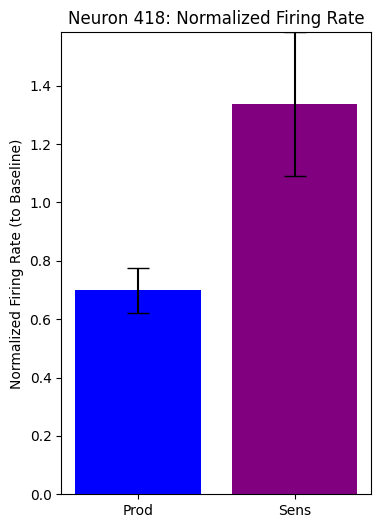

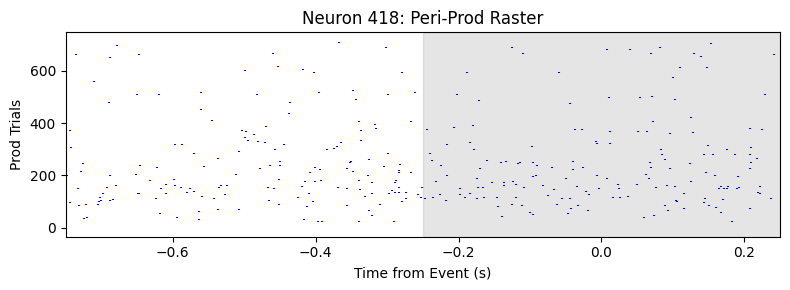

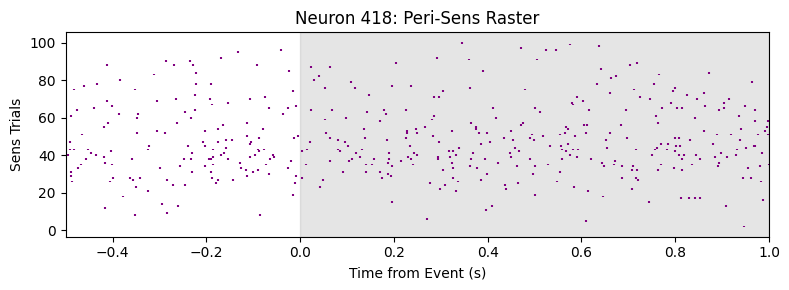

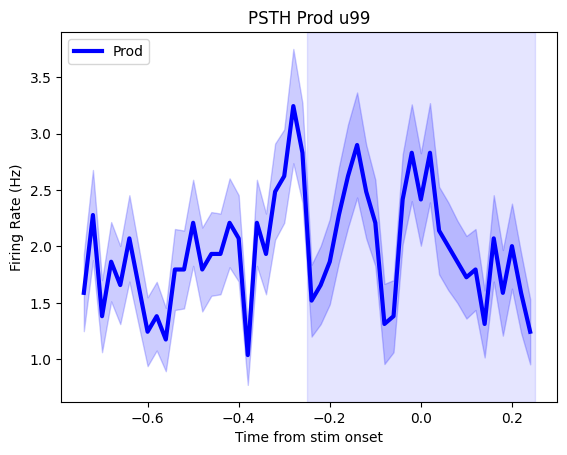

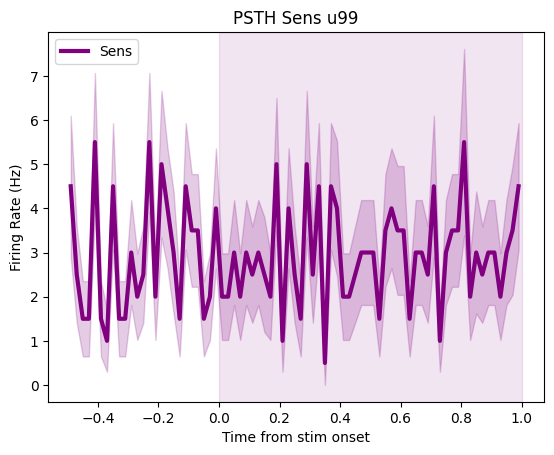

In [21]:
# Find indices where prod_pval < 0.05
prod_sig_idx = np.where(prod_pval < 0.05)[0]
# Find indices where sens_pval < 0.05
sens_sig_idx = np.where(sens_pval < 0.05)[0]
# Find indices where both conditions are met
both_sig_idx = np.intersect1d(prod_sig_idx, sens_sig_idx)

print("Indices with prod_pval < 0.05:", prod_sig_idx)
print("Indices with sens_pval < 0.05:", sens_sig_idx)
print("Indices with both prod_pval and sens_pval < 0.05:", both_sig_idx)

# Calculate percentage of neurons that respond to prod and sens
num_neurons = len(prod_pval)
num_prod_sig = len(prod_sig_idx)
num_sens_sig = len(sens_sig_idx)
num_both_sig = len(both_sig_idx)

perc_prod_sig = 100 * num_prod_sig / num_neurons
perc_sens_sig = 100 * num_sens_sig / num_neurons
perc_both_sig = 100 * num_both_sig / num_neurons

print(f"Percentage of neurons responsive to prod: {perc_prod_sig:.2f}%")
print(f"Percentage of neurons responsive to sens: {perc_sens_sig:.2f}%")
print(f"Percentage of neurons responsive to both: {perc_both_sig:.2f}%")

# no visualize the responsive neurons
prod_neuron_indices = indicesFinal[prod_sig_idx]
sens_neuron_indices = indicesFinal[sens_sig_idx]

print(sens_neuron_indices)
print(spike_times_good)
print(sens_pval[sens_sig_idx])

# now manually review the neurons to look for good examples
for example in sens_neuron_indices:
    # Calculate average firing rate during prod and sens for the example neuron
    example_spikes = spike_times_good[example]

    # Define prod and sens intervals for the example neuron
    prod_intervals = [nap.IntervalSet(start=s, end=e) for s, e in zip(prod_starts, prod_ends)]
    sens_intervals = [nap.IntervalSet(start=s, end=e) for s, e in zip(sens_starts, sens_ends)]

    # Calculate mean firing rate during prod and sens
    prod_rates = [len(example_spikes.restrict(interval)) / interval.tot_length('s') for interval in prod_intervals]
    sens_rates = [len(example_spikes.restrict(interval)) / interval.tot_length('s') for interval in sens_intervals]

    mean_prod_rate = np.mean(prod_rates)
    mean_sens_rate = np.mean(sens_rates)

    # Calculate 95% confidence intervals for prod and sens rates
    def ci95(data):
        n = len(data)
        if n > 1:
            m = np.mean(data)
            se = np.std(data, ddof=1) / np.sqrt(n)
            ci = 1.96 * se
            return ci
        else:
            return 0

    ci_prod_rate = ci95(prod_rates)
    ci_sens_rate = ci95(sens_rates)

    # Calculate baseline firing rate (using baseline_intervals)
    mean_baseline_rate = spike_times_good[example].rate

    # Normalize prod and sens rates to baseline
    norm_prod = mean_prod_rate / mean_baseline_rate if mean_baseline_rate > 0 else np.nan
    norm_sens = mean_sens_rate / mean_baseline_rate if mean_baseline_rate > 0 else np.nan

    # Calculate 95% CI for normalized rates
    norm_prod_ci = ci_prod_rate / mean_baseline_rate if mean_baseline_rate > 0 else np.nan
    norm_sens_ci = ci_sens_rate / mean_baseline_rate if mean_baseline_rate > 0 else np.nan

    # Bar plot with 95% confidence intervals as error bars
    plt.figure(figsize=(4, 6))
    plt.bar(['Prod', 'Sens'], [norm_prod, norm_sens], yerr=[norm_prod_ci, norm_sens_ci], color=['blue', 'purple'], capsize=8)
    plt.ylabel('Normalized Firing Rate (to Baseline)')
    plt.title(f'Neuron {example}: Normalized Firing Rate')
    plt.ylim(0, max(norm_prod + (norm_prod_ci if not np.isnan(norm_prod_ci) else 0), 
                    norm_sens + (norm_sens_ci if not np.isnan(norm_sens_ci) else 0), 1.5))
    plt.show()

    # Peri-event spike raster for the example neuron

    # We'll use prod_onsets and sens_onsets as event times
    # and plot rasters for both prod and sens events

    # Parameters
    window_prod = (-0.75, 0.25)
    window_sens = (-0.5, 1)

    # Helper function to get peri-event spike times for raster
    def get_perievent_spikes(spikes, event_times, window):
        rasters = []
        
        # Convert pynapple Ts object to numpy array
        if hasattr(spikes, 'as_series'):
            spikes_array = spikes.as_series().index.values
        elif hasattr(spikes, 'index'):
            spikes_array = spikes.index.values
        else:
            spikes_array = np.array(spikes)
        
        # Convert event times to numpy array
        if hasattr(event_times, 'as_series'):
            event_array = event_times.as_series().index.values
        elif hasattr(event_times, 'index'):
            event_array = event_times.index.values
        else:
            event_array = np.array(event_times)
        
        for onset_time in event_array:
            # Get spikes in window around event
            window_start = onset_time + window[0]
            window_end = onset_time + window[1]
            
            # Find spikes in the window
            mask = (spikes_array >= window_start) & (spikes_array <= window_end)
            rel_spikes = spikes_array[mask] - onset_time
            
            rasters.append(rel_spikes)
        
        return rasters

    # Get spike times relative to each event for prod and sens
    prod_raster = get_perievent_spikes(example_spikes, prod_onsets, window_prod)
    sens_raster = get_perievent_spikes(example_spikes, sens_onsets, window_sens)

    # Plot raster for prod
    fig_prod, ax_prod = plt.subplots(figsize=(8, 3))
    for i, trial_spikes in enumerate(prod_raster):
        ax_prod.vlines(trial_spikes, i + 0.5, i + 1.5, color='blue')
    # Lightly shade the last 0.5 seconds of the window
    prod_shade_start = window_prod[1] - 0.5
    prod_shade_end = window_prod[1]
    ax_prod.axvspan(prod_shade_start, prod_shade_end, color='gray', alpha=0.2)
    ax_prod.set_ylabel('Prod Trials')
    ax_prod.set_title(f'Neuron {example}: Peri-Prod Raster')
    ax_prod.set_xlim(window_prod)
    ax_prod.set_xlabel('Time from Event (s)')
    plt.tight_layout()
    plt.show()

    # Plot raster for sens
    fig_sens, ax_sens = plt.subplots(figsize=(8, 3))
    for i, trial_spikes in enumerate(sens_raster):
        ax_sens.vlines(trial_spikes, i + 0.5, i + 1.5, color='purple')
    # Lightly shade the last 0.5 seconds of the window
    sens_shade_start = window_sens[1] - window_sens[1]
    sens_shade_end = window_sens[1]
    ax_sens.axvspan(sens_shade_start, sens_shade_end, color='gray', alpha=0.2)
    ax_sens.set_ylabel('Sens Trials')
    ax_sens.set_title(f'Neuron {example}: Peri-Sens Raster')
    ax_sens.set_xlim(window_sens)
    ax_sens.set_xlabel('Time from Event (s)')
    plt.tight_layout()
    plt.show()


    # now plot firing rate curve
    runList = [example]
    for neuron in runList:
        prod_psth = nap.compute_perievent(spike_times_good[neuron], tref = prod_onsets, minmax=(-0.75, 0.25), time_unit="s")
        sens_psth = nap.compute_perievent(spike_times_good[neuron], tref = sens_onsets, minmax=(-0.5, 1), time_unit="s")

    smooth = 0.02
    prod_mean = np.mean(prod_psth.count(smooth), 1) / smooth
    prod_sem = np.std(prod_psth.count(smooth), 1) / (smooth * np.sqrt(prod_psth.count(smooth).shape[1]))

    sens_mean = np.mean(sens_psth.count(smooth), 1) / smooth
    sens_sem = np.std(sens_psth.count(smooth), 1) / (smooth * np.sqrt(sens_psth.count(smooth).shape[1]))

    # Plot Prod PSTH
    plt.figure()
    plt.plot(prod_mean, linewidth=3, color="blue", label="Prod")
    plt.fill_between(prod_mean.t, prod_mean.d-prod_sem.d, prod_mean.d+prod_sem.d, color="blue", alpha=0.2)
    plt.axvspan(-0.25, 0.25, color="blue", alpha=0.1)
    plt.ylabel("Firing Rate (Hz)")
    plt.xlabel("Time from stim onset")
    plt.legend()
    plt.title(f"PSTH Prod u{u}")
    plt.show()

    # Plot Sens PSTH
    plt.figure()
    plt.plot(sens_mean, linewidth=3, color="purple", label="Sens")
    plt.fill_between(sens_mean.t, sens_mean.d-sens_sem.d, sens_mean.d+sens_sem.d, color="purple", alpha=0.2)
    plt.axvspan(0, 1, color="purple", alpha=0.1)
    plt.ylabel("Firing Rate (Hz)")
    plt.xlabel("Time from stim onset")
    plt.legend()
    plt.title(f"PSTH Sens u{u}")
    plt.show()

814
1023


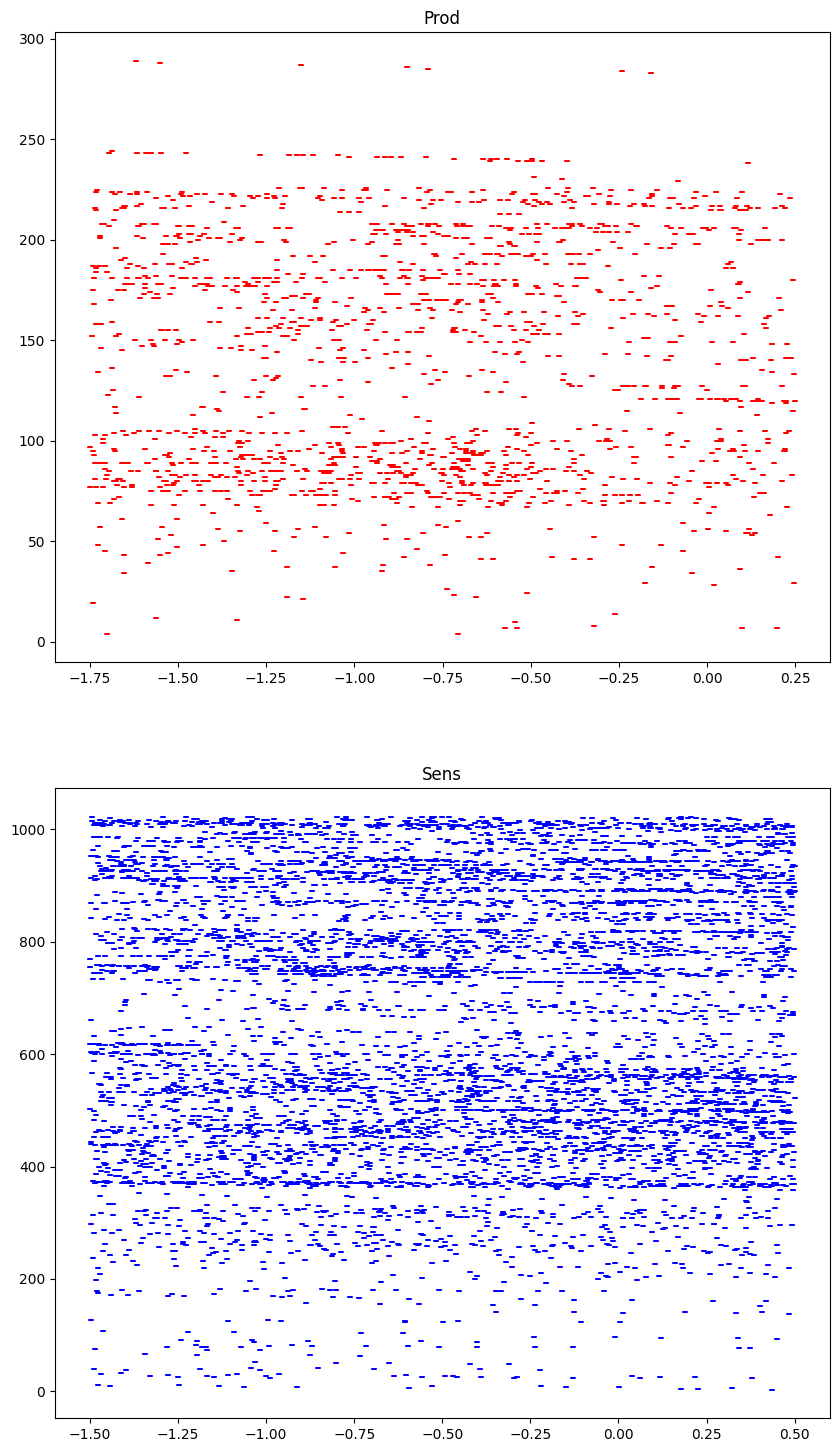

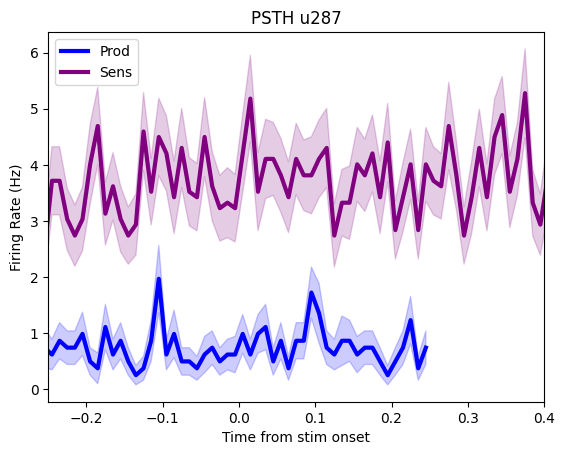

In [307]:
# plot example neurons

# get perievent activity and define responsive neurons
u = example
runList = [u]
for neuron in runList:
    prod_psth = nap.compute_perievent(spike_times_good[neuron], tref = prod_onsets, minmax=(-1.75, 0.25), time_unit="s")
    sens_psth = nap.compute_perievent(spike_times_good[neuron], tref = sens_onsets, minmax=(-1.5, 0.5), time_unit="s")

print(len(prod_onsets))
print(len(sens_onsets))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 18))
ax1.plot(prod_psth.to_tsd(), "|", markersize=2, color="red", mew=4)
ax1.set_title("Prod")
ax2.plot(sens_psth.to_tsd(), "|", markersize=2, color="blue", mew=4)
ax2.set_title("Sens")
plt.show()

prod_mean = np.mean(prod_psth.count(0.01), 1) / 0.01
prod_sem = np.std(prod_psth.count(0.01), 1) / (0.01 * np.sqrt(prod_psth.count(0.01).shape[1]))

sens_mean = np.mean(sens_psth.count(0.01), 1) / 0.01
sens_sem = np.std(sens_psth.count(0.01), 1) / (0.01 * np.sqrt(sens_psth.count(0.01).shape[1]))

plt.plot(prod_mean, linewidth=3, color="blue", label="Prod")
plt.fill_between(prod_mean.t, prod_mean.d-prod_sem.d, prod_mean.d+prod_sem.d, color="blue", alpha=0.2)
plt.plot(sens_mean, linewidth=3, color="purple", label="Sens")
plt.fill_between(sens_mean.t, sens_mean.d-sens_sem.d, sens_mean.d+sens_sem.d, color="purple", alpha=0.2)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time from stim onset")
plt.legend()
plt.title(f"PSTH u{u}")
plt.xlim(-0.25, 0.4)
plt.show()